# Global Terrorism Data Analysis

#### Matthew Terribile, September 2017

#### Goal:  
This project is to analyze the Global Terrorism Database (http://start.umd.edu/gtd/) which includes data on terrorist attacks between 1970 and 2016, excluding 1993.  Work will include:
- Perform exploratory data analysis
- Impute missing 1993 values
- Examine differences in frequency of attacks using Bayesian techniques

#### Executive Summary:
- Global Terrorism varies by both time and location
- The amount of terrorism over time can most closely be modeled by an AR=1 autoregressive model, i.e.- the previous year’s value is most useful for predicting the current year’s value.   
- Significant events, like peace accords in Guatemala, appear to lesson terrorism in that area

In [1]:
# Import packages
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
import datetime
import statsmodels.api as sm 

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in Global Terrorism file
gtd=pd.read_csv('globalterrorismdb_0617dist.csv')

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Do basic EDA to look at the file

In [4]:
gtd.shape

(170350, 135)

In [5]:
gtd.head(4)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,

In [6]:
# Check 'Attack Type' (independent variable) for null values - aren't any
gtd.attacktype1_txt.value_counts()

Bombing/Explosion                      83073
Armed Assault                          40223
Assassination                          18402
Hostage Taking (Kidnapping)            10233
Facility/Infrastructure Attack          9581
Unknown                                 6425
Unarmed Assault                          913
Hostage Taking (Barricade Incident)      902
Hijacking                                598
Name: attacktype1_txt, dtype: int64

In [7]:
# Check that Attack Type is an integer
gtd.attacktype1.dtypes

dtype('int64')

##### Observations from EDA: 
- many rows - one per incident 
- 135 columns, some more interesting than others
- many entries will be null - some columns are optional data

##### Look at a subset of the data aggregated by year 

In [8]:
# Set up data frame with total attacks by year
gty= pd.DataFrame(gtd.groupby('iyear').attacktype1.agg('count'))
gty.columns=['Total_attacks']

gty.head(2)

,Total_attacks
iyear,
1970,651
1971,470


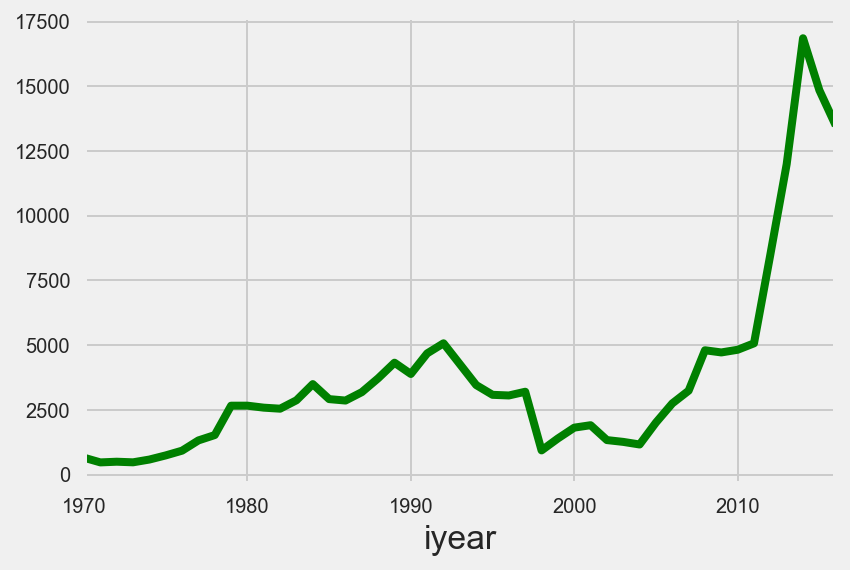

In [9]:
# Do a quick plot of the total attacks

ax1=sns.tsplot(gty.Total_attacks,time=gty.index, color='G')

In [10]:
# Add the number of events by attack type

for attack in range(1,10):
    gty[attack]= gtd[(gtd.attacktype1==attack)].groupby('iyear').attacktype1.agg('count')

# Rename columns
attack_dict = {4:'Hijacking',9:'Unknown',5:'Hostage Taking (Barricade Incident)',
               1:'Assassination',3:'Bombing/Explosion',
               7:'Facility/Infrastructure Attack',6:'Hostage Taking (Kidnapping)',
               8:'Unarmed Assault', 2: 'Armed Assault'}
gty.rename(columns=attack_dict,inplace=True)
gty.head(2)


,Total_attacks,Assassination,Armed Assault,Bombing/Explosion,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Facility/Infrastructure Attack,Unarmed Assault,Unknown
iyear,,,,,,,,,,
1970,651,22,61,333,11.0,3.0,38,174,3.0,6
1971,470,70,44,238,6.0,1.0,20,88,NaN,3


In [11]:
# Add number of events by region to data frame

for region in range(1,13):
    gty[region]= gtd[(gtd.region==region)].groupby('iyear').attacktype1.agg('count')

# Rename columns, eliminate spaces for easier referencing
region_dict = {4:'East_Asia',9:'Eastern_Europe',5:'Southeast_Asia',12:'Australasia&Oceania',
               1:'North_America',3:'South_America',11:'Sub-Saharan_Africa',7:'Central_Asia',
               10:'Middle_East&North_Africa',6:'South_Asia',8:'Western_Europe',
               2:'Central_America_Caribbean'}
gty.rename(columns=region_dict,inplace=True)


In [12]:
# Change NaNs to 0 in consolidated data frame
gty.fillna(value=0,inplace=True)
gty.head(2)

,Total_attacks,Assassination,Armed Assault,Bombing/Explosion,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Facility/Infrastructure Attack,Unarmed Assault,Unknown,North_America,Central_America_Caribbean,South_America,East_Asia,Southeast_Asia,South_Asia,Central_Asia,Western_Europe,Eastern_Europe,Middle_East&North_Africa,Sub-Saharan_Africa,Australasia&Oceania
iyear,,,,,,,,,,,,,,,,,,,,,,
1970,651,22,61,333,11.0,3.0,38,174,3.0,6,472,7.0,65,2.0,10,1.0,0.0,49,12.0,29,3.0,1.0
1971,470,70,44,238,6.0,1.0,20,88,0.0,3,247,5.0,24,1.0,6,0.0,0.0,125,4.0,55,2.0,1.0


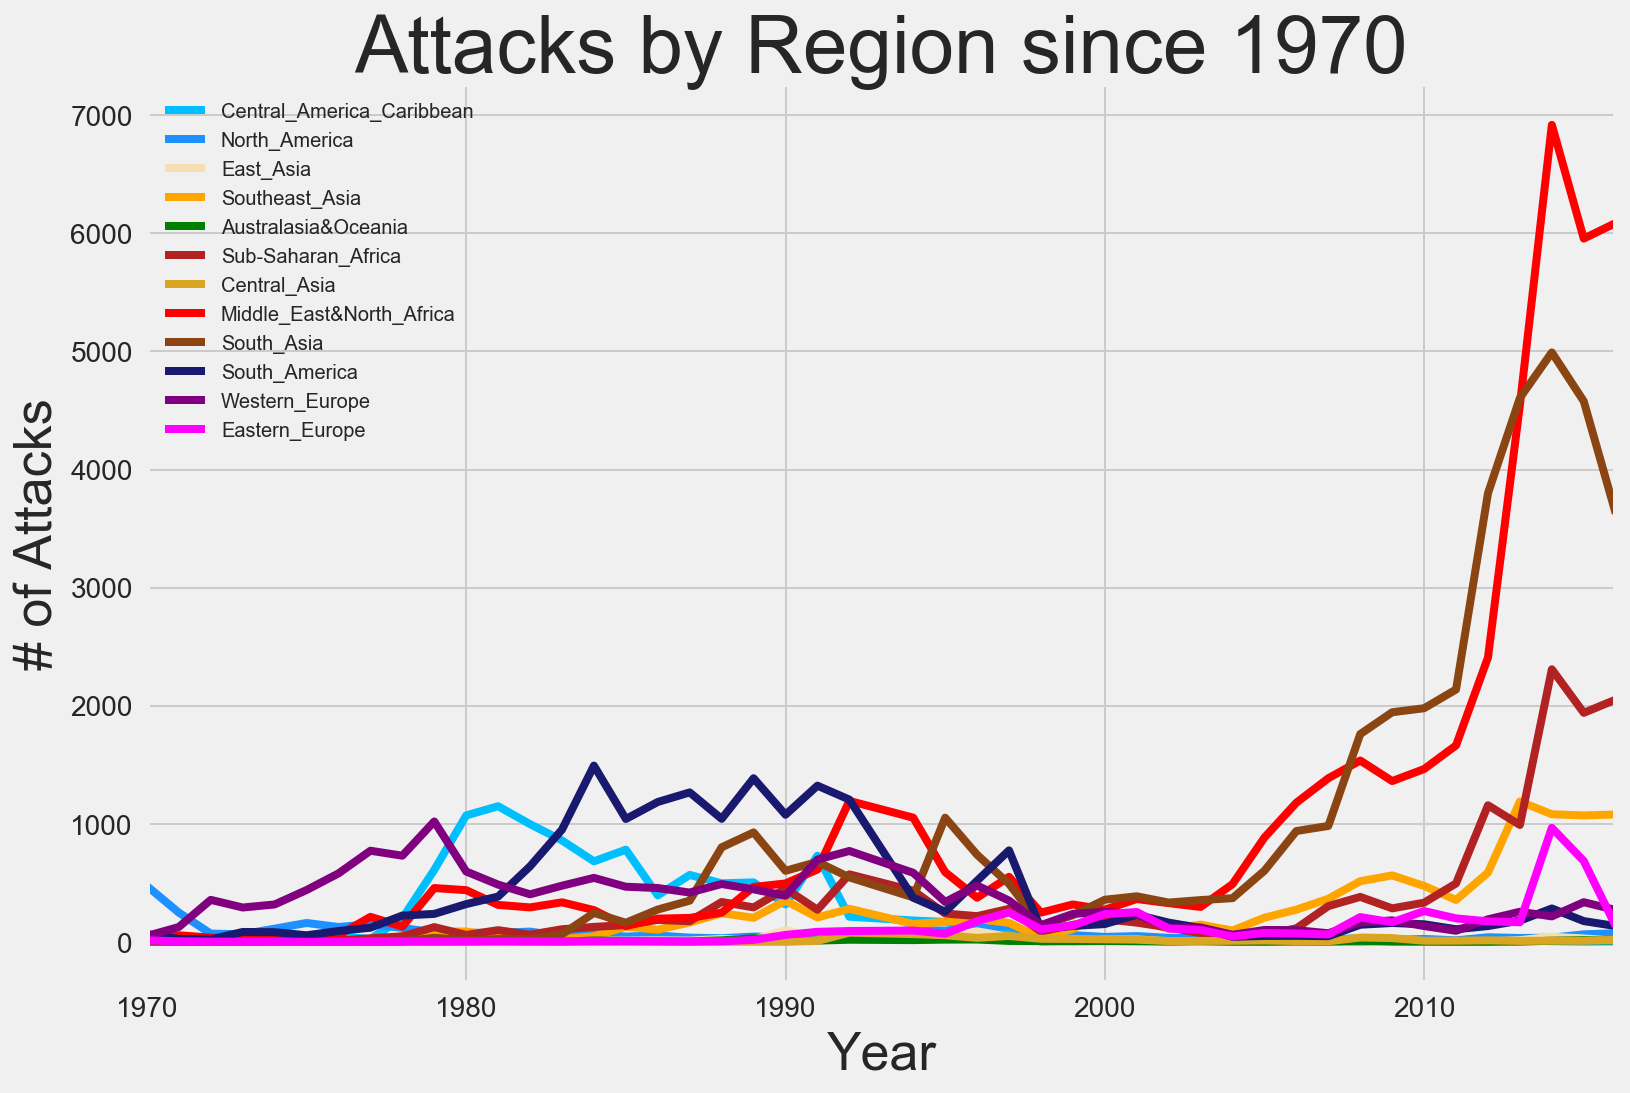

In [13]:
# Plot by region for entire period. (Using Seaborn time series plot.)

fig=plt.figure(figsize=(12,8))
plt.title('Attacks by Region since 1970',fontsize=40)
ax1=sns.tsplot(gty['Central_America_Caribbean'],time=gty.index, color='deepskyblue',condition='Central_America_Caribbean')
ax2=sns.tsplot(gty['North_America'],time=gty.index, color='dodgerblue',condition= 'North_America')
ax3=sns.tsplot(gty['East_Asia'],time=gty.index, color='wheat',condition= 'East_Asia')
ax4=sns.tsplot(gty['Southeast_Asia'],time=gty.index, color='orange',condition= 'Southeast_Asia')
ax5=sns.tsplot(gty['Australasia&Oceania'],time=gty.index, color='green',condition= 'Australasia&Oceania')
ax6=sns.tsplot(gty['Sub-Saharan_Africa'],time=gty.index, color='firebrick',condition= 'Sub-Saharan_Africa')
ax7=sns.tsplot(gty['Central_Asia'],time=gty.index, color='goldenrod',condition= 'Central_Asia')
ax8=sns.tsplot(gty['Middle_East&North_Africa'],time=gty.index, color='red',condition= 'Middle_East&North_Africa')
ax9=sns.tsplot(gty['South_Asia'],time=gty.index, color='saddlebrown',condition= 'South_Asia')
ax10=sns.tsplot(gty['South_America'],time=gty.index, color='midnightblue',condition= 'South_America')
ax11=sns.tsplot(gty['Western_Europe'],time=gty.index, color='purple',condition= 'Western_Europe')
ax12=sns.tsplot(gty['Eastern_Europe'],time=gty.index, color='magenta',condition= 'Eastern_Europe')
plt.ylabel('# of Attacks',fontsize=26)
plt.xlabel('Year',fontsize=26)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.1)
plt.savefig('Attacks by region.png')


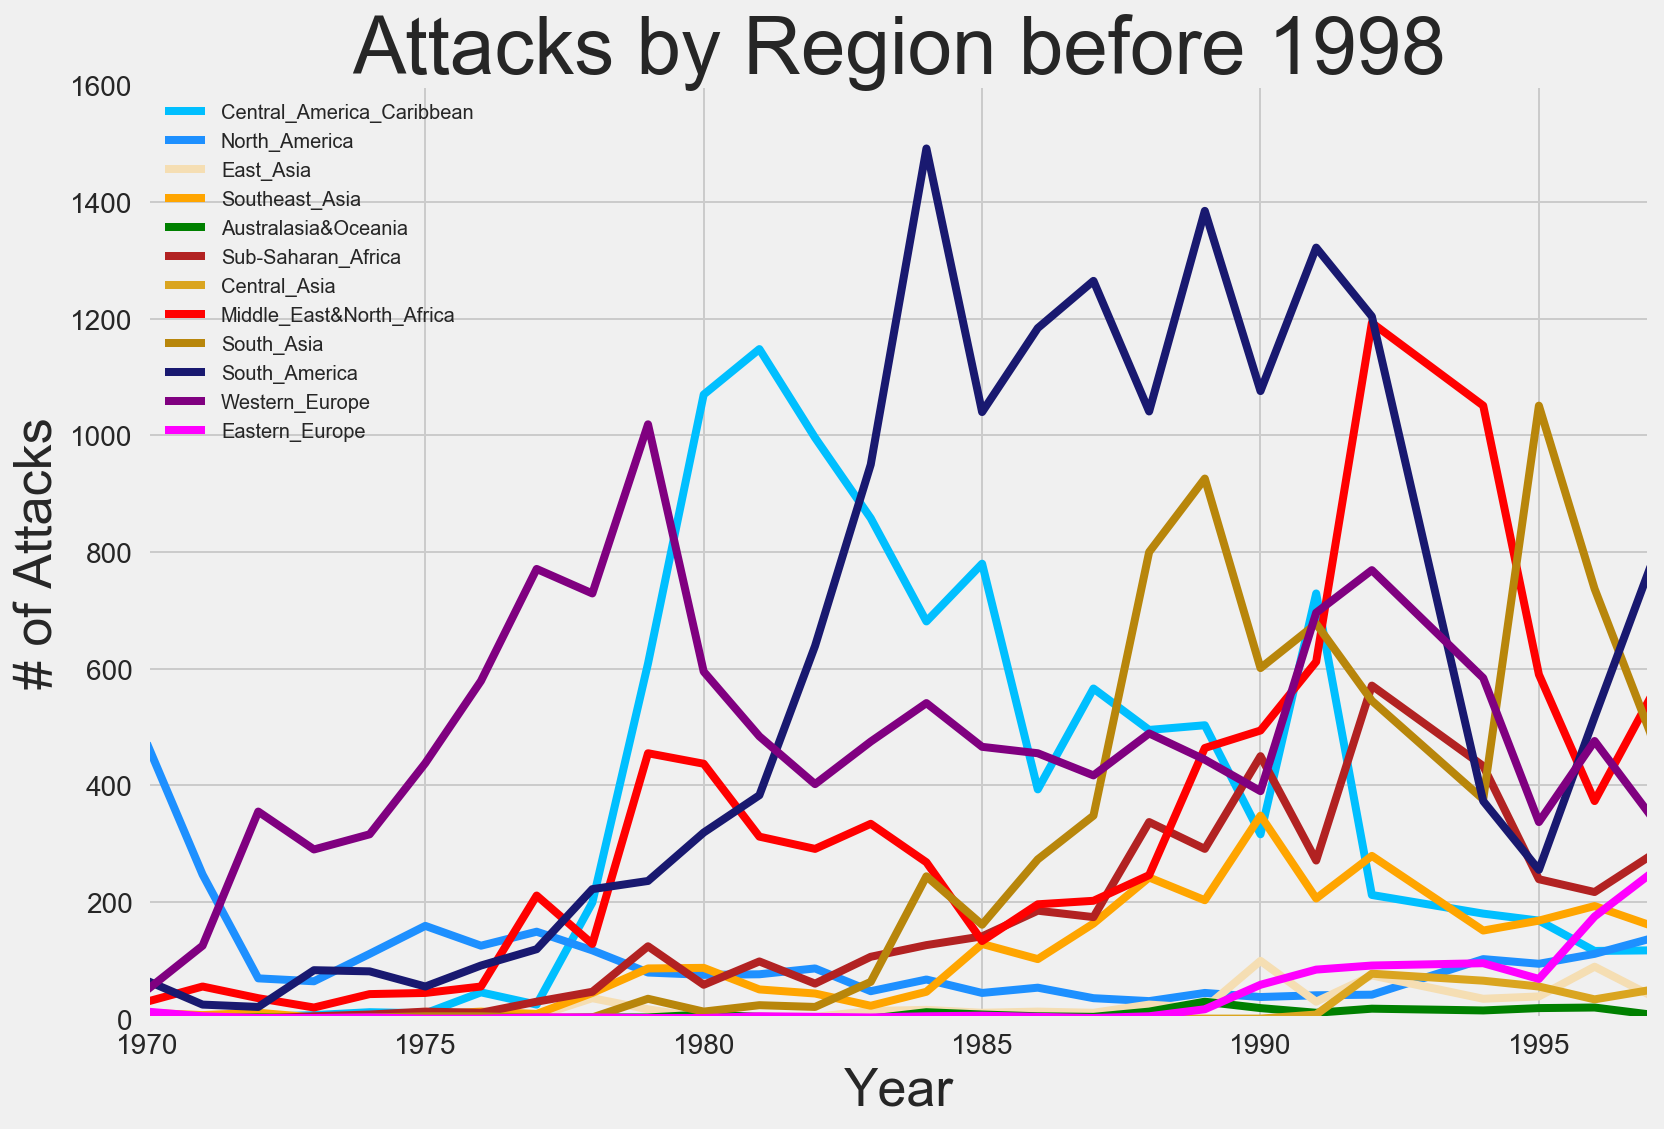

In [14]:
# Plot by region for period for only prior to 1998

fig=plt.figure(figsize=(12,8))
plt.title('Attacks by Region before 1998',fontsize=40)
ax1=sns.tsplot(gty['Central_America_Caribbean'],time=gty.index, color='deepskyblue',condition='Central_America_Caribbean')
ax2=sns.tsplot(gty['North_America'],time=gty.index, color='dodgerblue',condition= 'North_America')
ax3=sns.tsplot(gty['East_Asia'],time=gty.index, color='wheat',condition= 'East_Asia')
ax4=sns.tsplot(gty['Southeast_Asia'],time=gty.index, color='orange',condition= 'Southeast_Asia')
ax5=sns.tsplot(gty['Australasia&Oceania'],time=gty.index, color='green',condition= 'Australasia&Oceania')
ax6=sns.tsplot(gty['Sub-Saharan_Africa'],time=gty.index, color='firebrick',condition= 'Sub-Saharan_Africa')
ax7=sns.tsplot(gty['Central_Asia'],time=gty.index, color='goldenrod',condition= 'Central_Asia')
ax8=sns.tsplot(gty['Middle_East&North_Africa'],time=gty.index, color='red',condition= 'Middle_East&North_Africa')
ax9=sns.tsplot(gty['South_Asia'],time=gty.index, color='darkgoldenrod',condition= 'South_Asia')
ax10=sns.tsplot(gty['South_America'],time=gty.index, color='midnightblue',condition= 'South_America')
ax11=sns.tsplot(gty['Western_Europe'],time=gty.index, color='purple',condition= 'Western_Europe')
ax12=sns.tsplot(gty['Eastern_Europe'],time=gty.index, color='magenta',condition= 'Eastern_Europe')
plt.xlim(1970,1997)
plt.ylim(0,1600)
x_vals = [1970,1975,1980,1985,1990,1995]
plt.xticks(x_vals)
plt.ylabel('# of Attacks',fontsize=26)
plt.xlabel('Year',fontsize=26)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

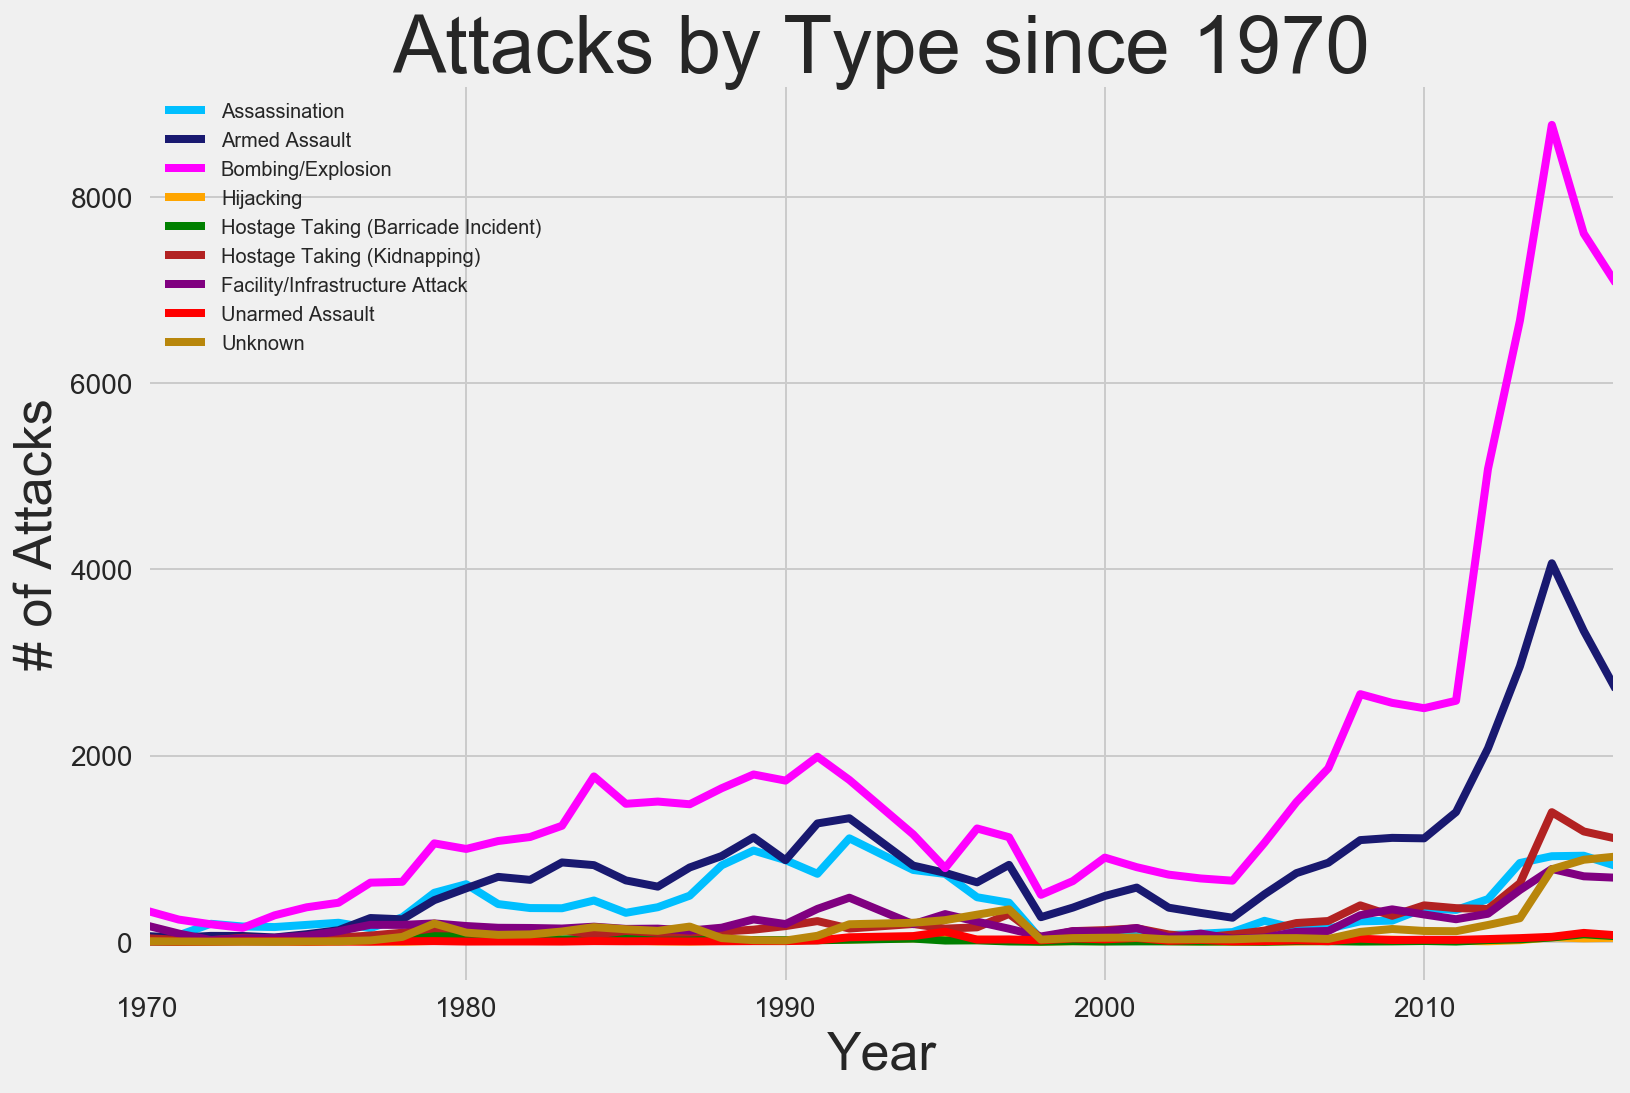

In [15]:
# Plot by attack type for entire period

fig=plt.figure(figsize=(12,8))
plt.title('Attacks by Type since 1970',fontsize=40)
ax1=sns.tsplot(gty['Assassination'],time=gty.index, color='deepskyblue',condition='Assassination')
ax2=sns.tsplot(gty['Armed Assault'],time=gty.index, color='midnightblue',condition= 'Armed Assault')
ax3=sns.tsplot(gty['Bombing/Explosion'],time=gty.index, color='magenta',condition= 'Bombing/Explosion')
ax4=sns.tsplot(gty['Hijacking'],time=gty.index, color='orange',condition= 'Hijacking')
ax5=sns.tsplot(gty['Hostage Taking (Barricade Incident)'],time=gty.index, color='green',condition= 'Hostage Taking (Barricade Incident)')
ax6=sns.tsplot(gty['Hostage Taking (Kidnapping)'],time=gty.index, color='firebrick',condition= 'Hostage Taking (Kidnapping)')
ax7=sns.tsplot(gty['Facility/Infrastructure Attack'],time=gty.index, color='purple',condition= 'Facility/Infrastructure Attack')
ax8=sns.tsplot(gty['Unarmed Assault'],time=gty.index, color='red',condition= 'Unarmed Assault')
ax9=sns.tsplot(gty['Unknown'],time=gty.index, color='darkgoldenrod',condition= 'Unknown')
plt.ylabel('# of Attacks',fontsize=26)
plt.xlabel('Year',fontsize=26)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.1)
plt.savefig('Attacks by type.png')


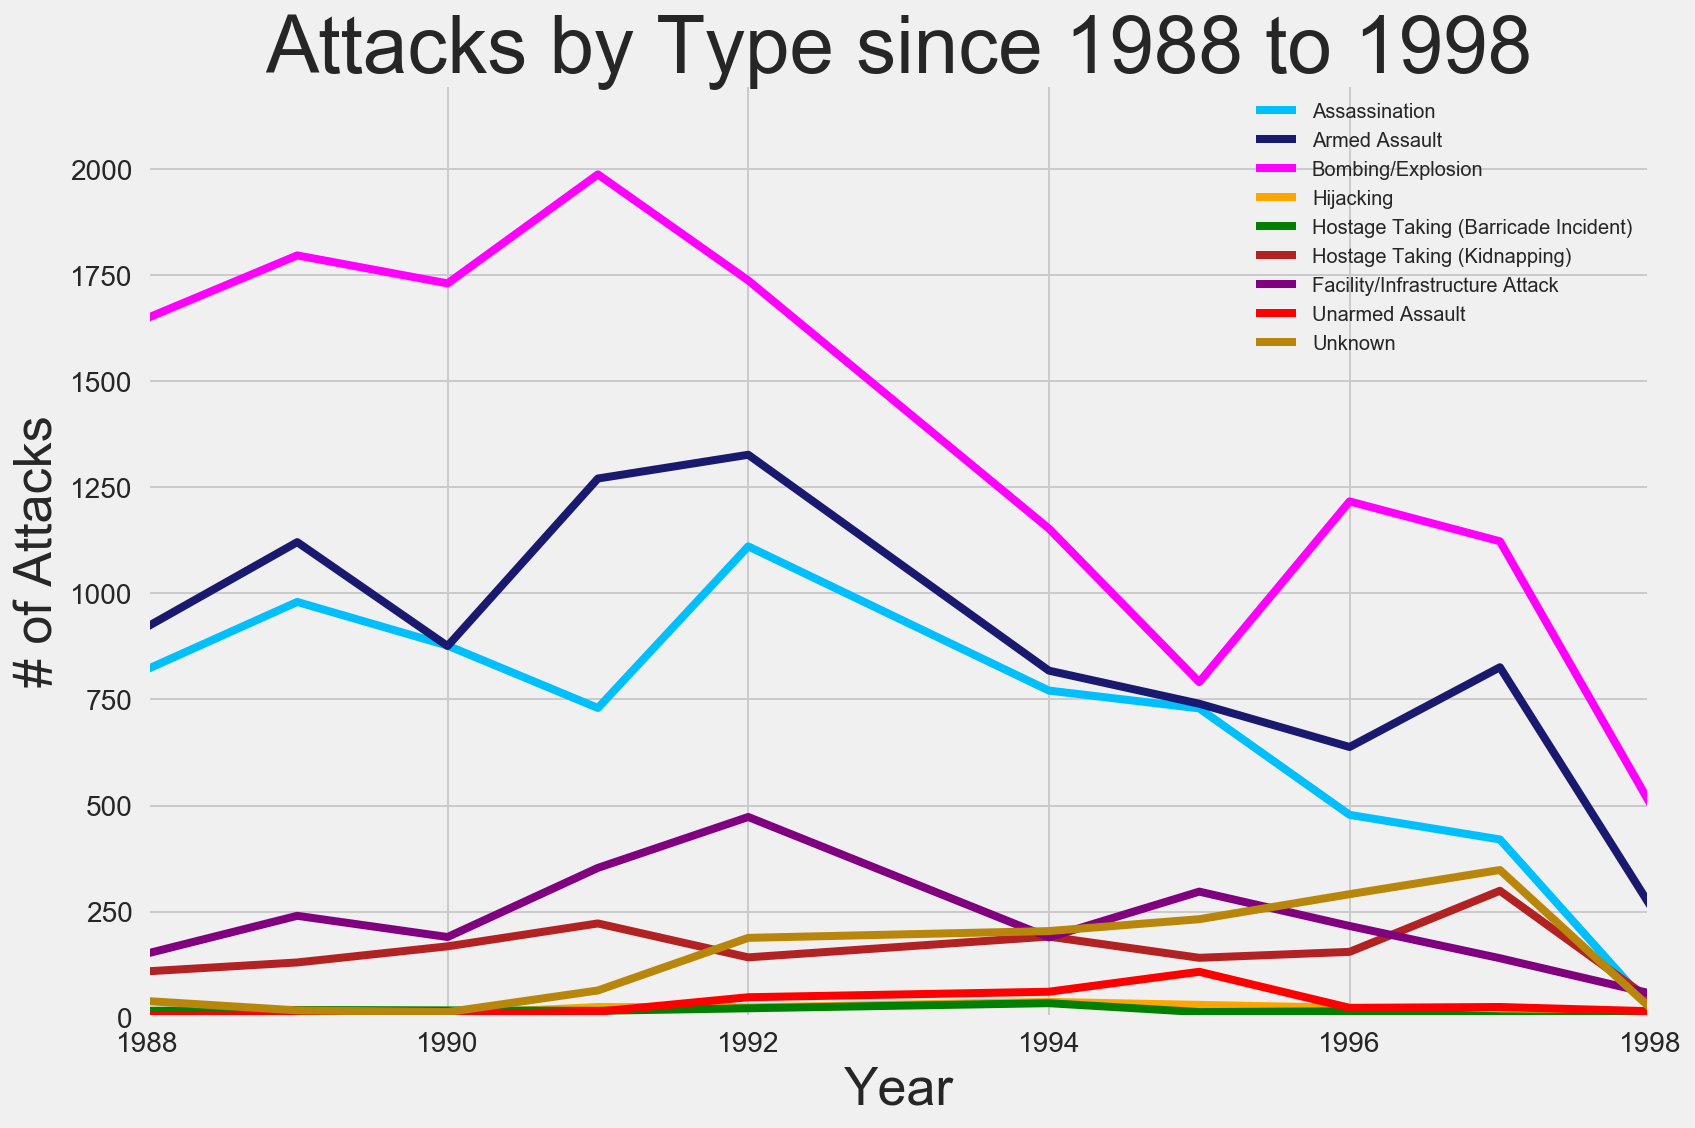

In [16]:
# Plot by attack type for 1988 to 1998

fig=plt.figure(figsize=(12,8))
plt.title('Attacks by Type since 1988 to 1998',fontsize=40)
#plt.style.use('seaborn-white')
plt.ylabel('# of Attacks',fontsize=30)
ax1=sns.tsplot(gty['Assassination'],time=gty.index, color='deepskyblue',condition='Assassination')
ax2=sns.tsplot(gty['Armed Assault'],time=gty.index, color='midnightblue',condition= 'Armed Assault')
ax3=sns.tsplot(gty['Bombing/Explosion'],time=gty.index, color='magenta',condition= 'Bombing/Explosion')
ax4=sns.tsplot(gty['Hijacking'],time=gty.index, color='orange',condition= 'Hijacking')
ax5=sns.tsplot(gty['Hostage Taking (Barricade Incident)'],time=gty.index, color='green',condition= 'Hostage Taking (Barricade Incident)')
ax6=sns.tsplot(gty['Hostage Taking (Kidnapping)'],time=gty.index, color='firebrick',condition= 'Hostage Taking (Kidnapping)')
ax7=sns.tsplot(gty['Facility/Infrastructure Attack'],time=gty.index, color='purple',condition= 'Facility/Infrastructure Attack')
ax8=sns.tsplot(gty['Unarmed Assault'],time=gty.index, color='red',condition= 'Unarmed Assault')
ax9=sns.tsplot(gty['Unknown'],time=gty.index, color='darkgoldenrod',condition= 'Unknown')
plt.xlim(1988,1998)
plt.ylim(0,2200)
x_vals = [1988,1990,1992,1994,1996,1998]
plt.xticks(x_vals)
plt.ylabel('# of Attacks',fontsize=26)
plt.xlabel('Year',fontsize=26)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

##### Observations from graphs of aggregated data:
- Sharp increase in attacks starting in about 2004
- Different types of attacks show similar trends over time
- Trends by region vary over time

### Want to estimate bombings in 1993
1993 data was missing from the data set.

##### First study time series to understand year to year relationships

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


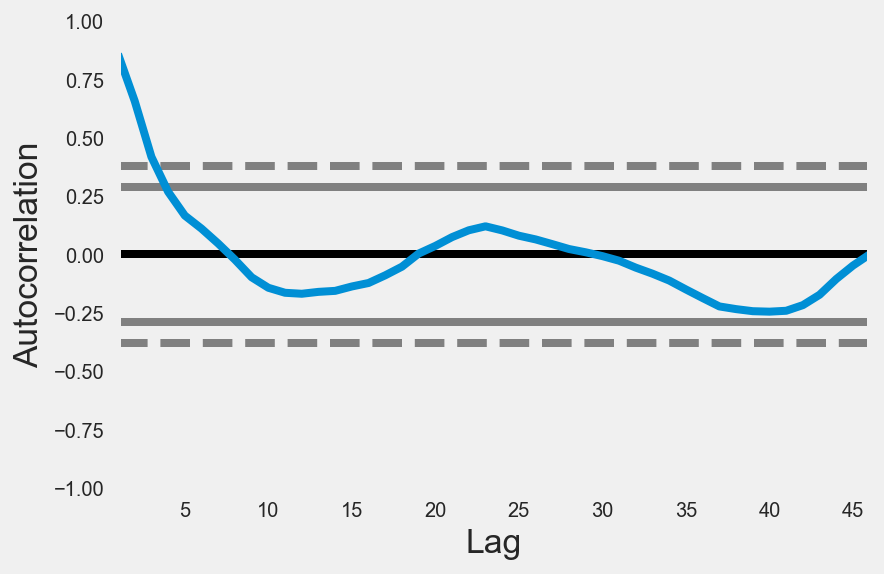

In [17]:
# See how much autocorrelation there is on attacks

from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(gty.Total_attacks)

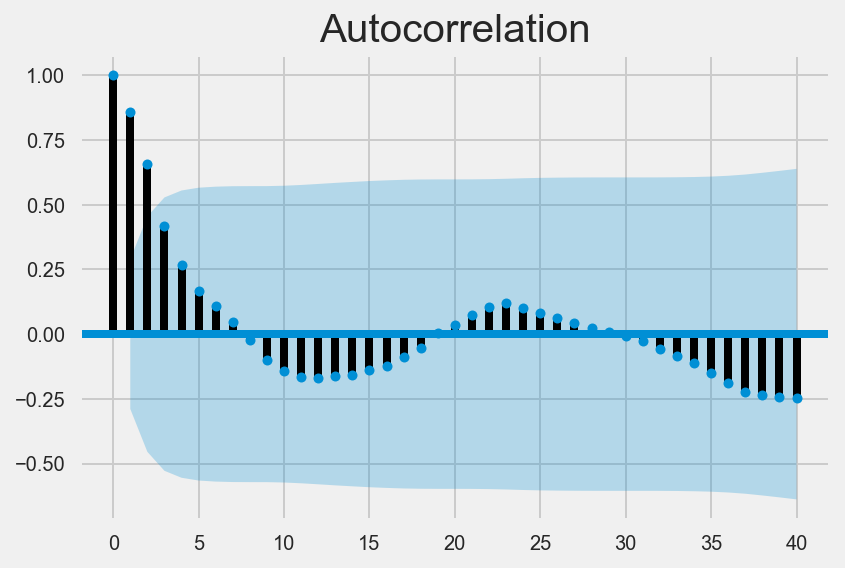

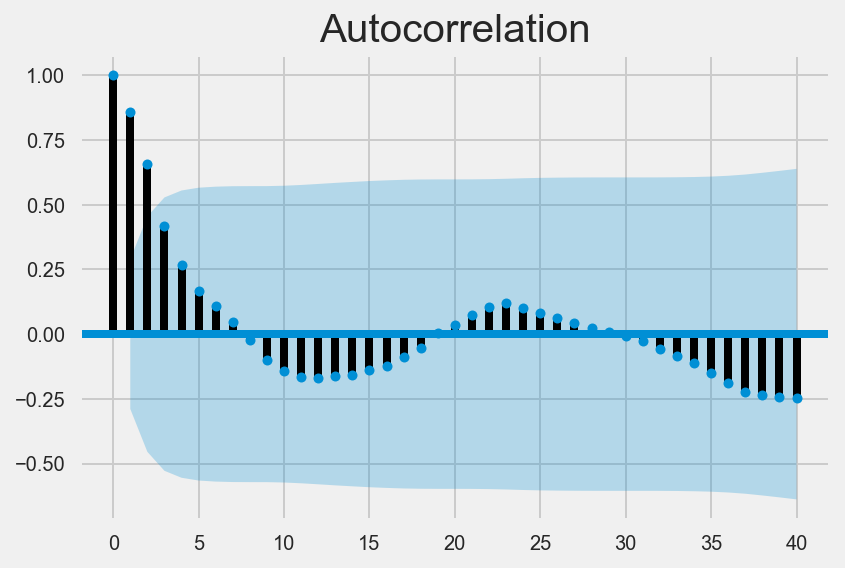

In [18]:
# Statsmodel version of this plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(gty.Total_attacks, lags=40)

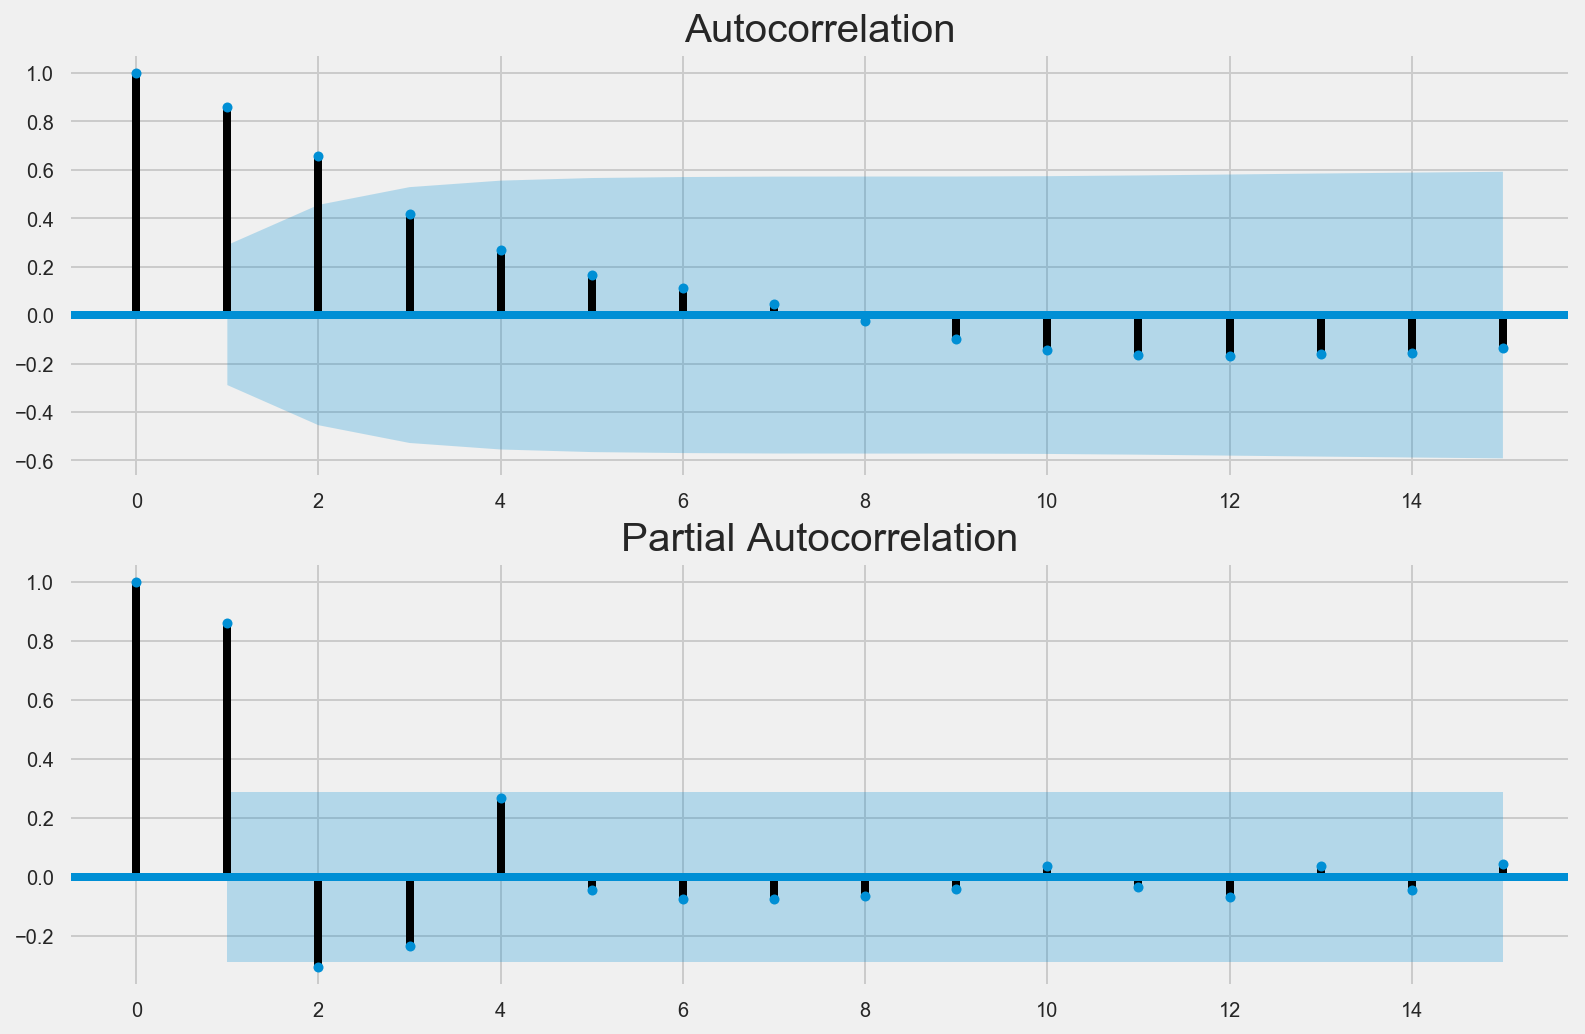

In [19]:
# Plot acf and pacf together
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gty.Total_attacks, lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gty.Total_attacks, lags=15, ax=ax2)

In [20]:
# Looks like an AR model with AR = 1
# ARMA runs below confirm that

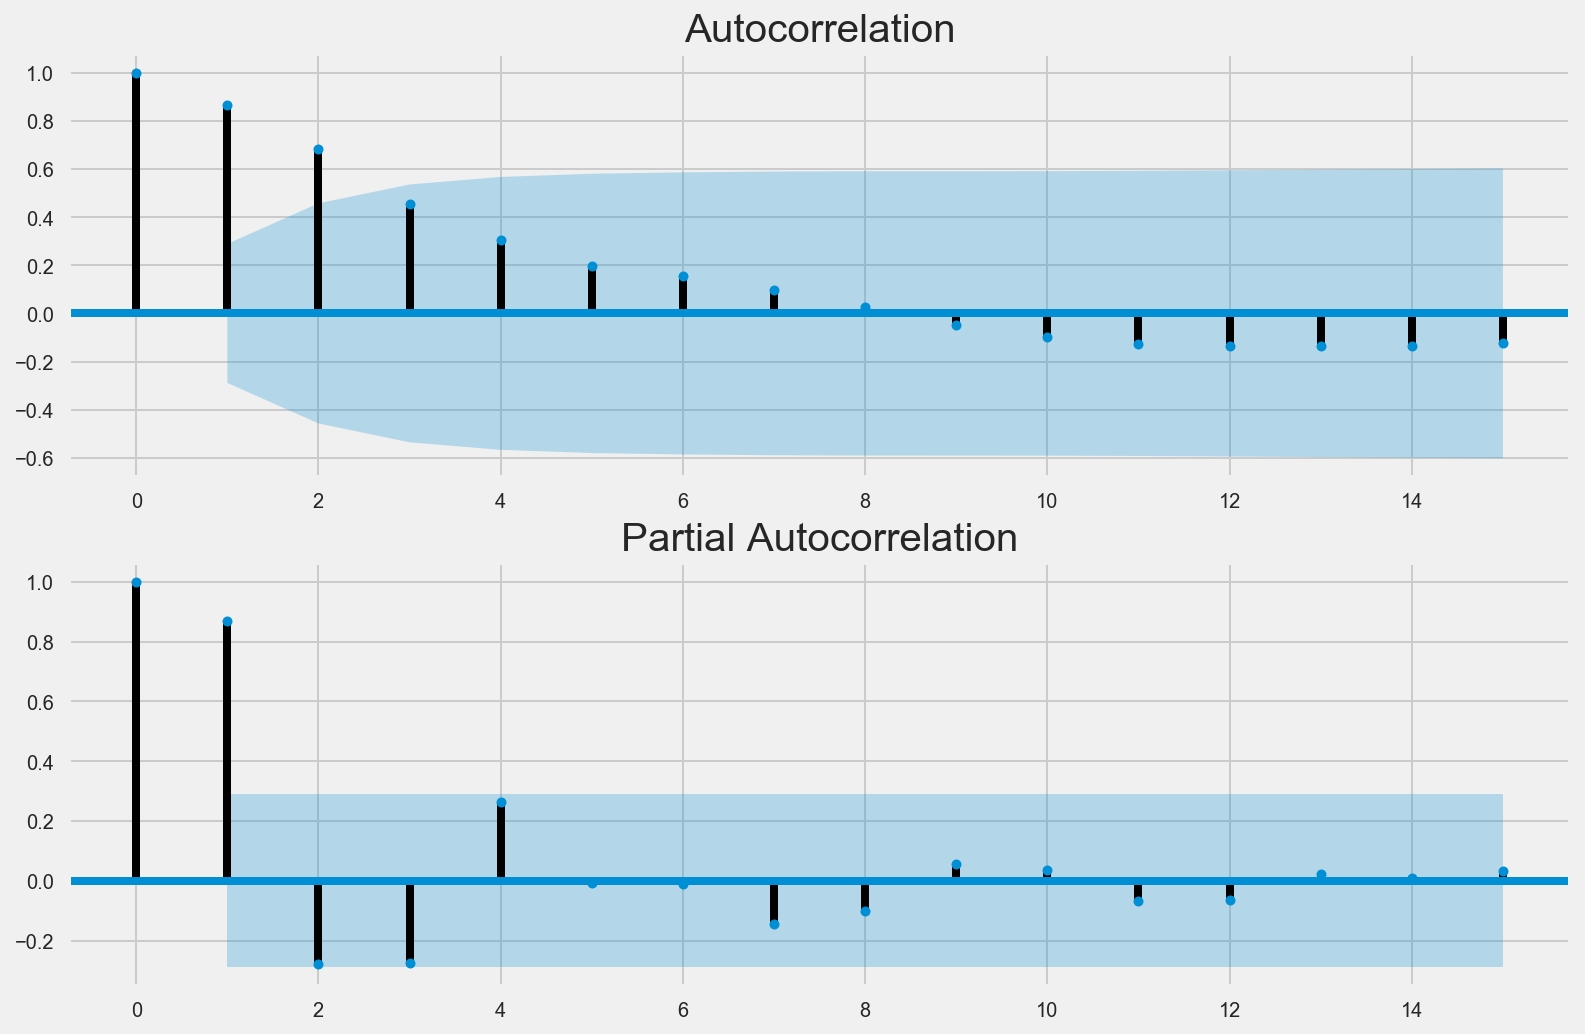

In [21]:
# Check if similar for just bombings
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gty['Bombing/Explosion'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gty['Bombing/Explosion'], lags=15, ax=ax2)

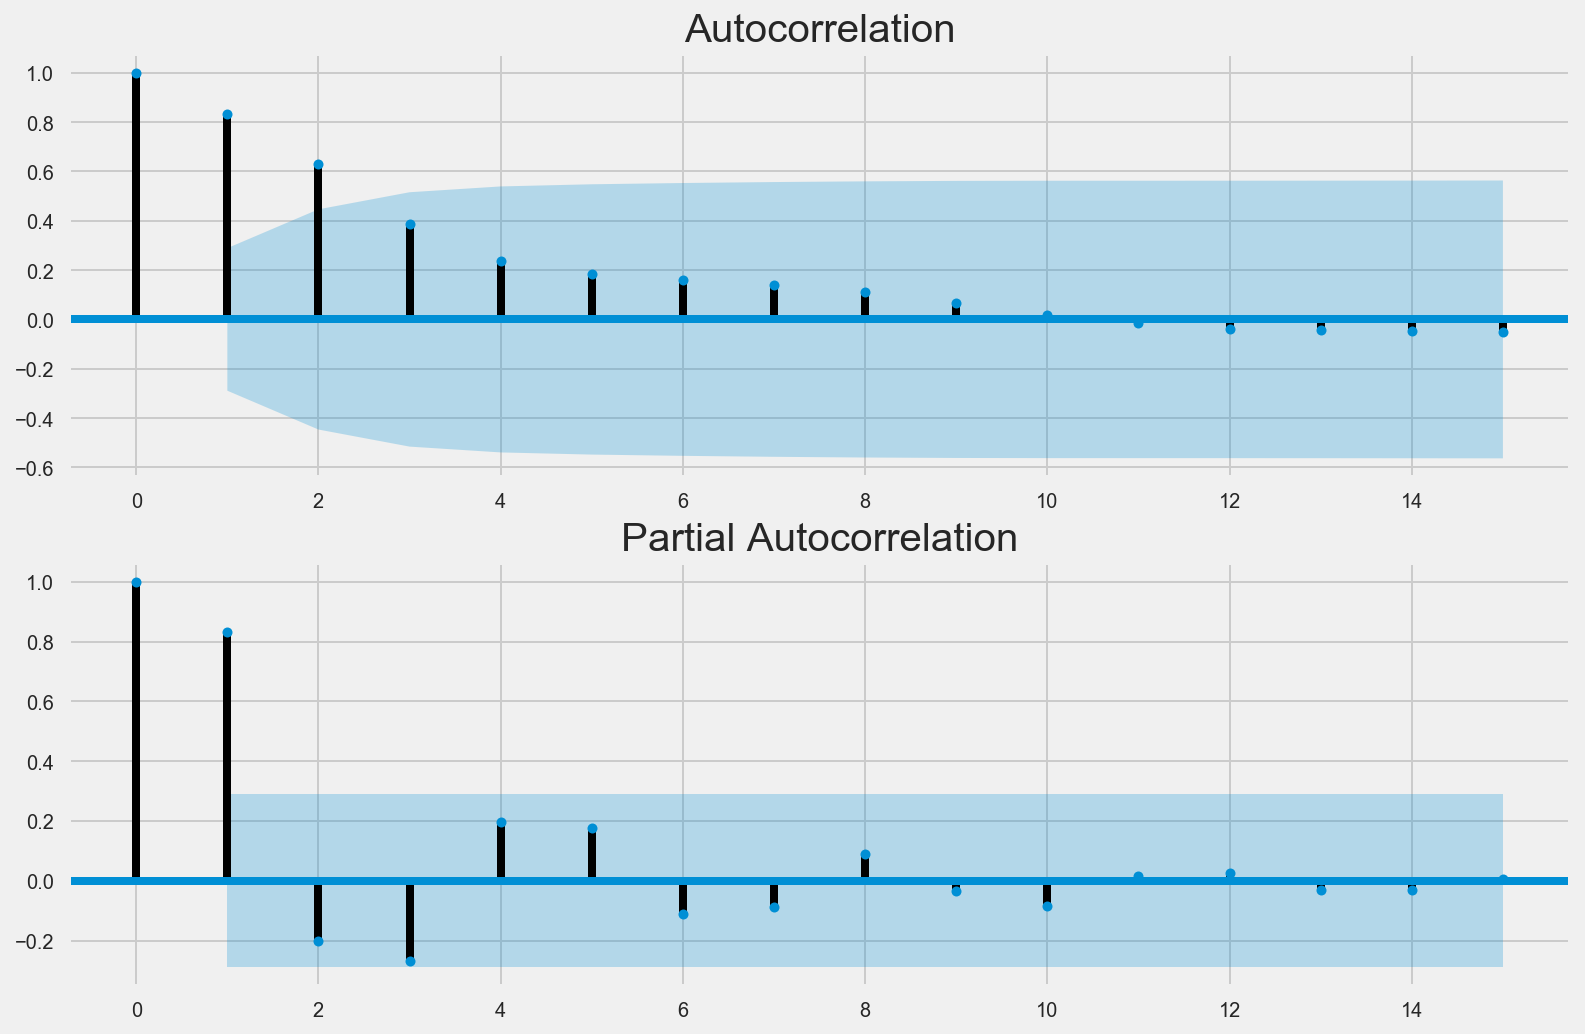

In [22]:
# Check for a few regions to see if also AR = 1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gty['Middle_East&North_Africa'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gty['Middle_East&North_Africa'], lags=15, ax=ax2)

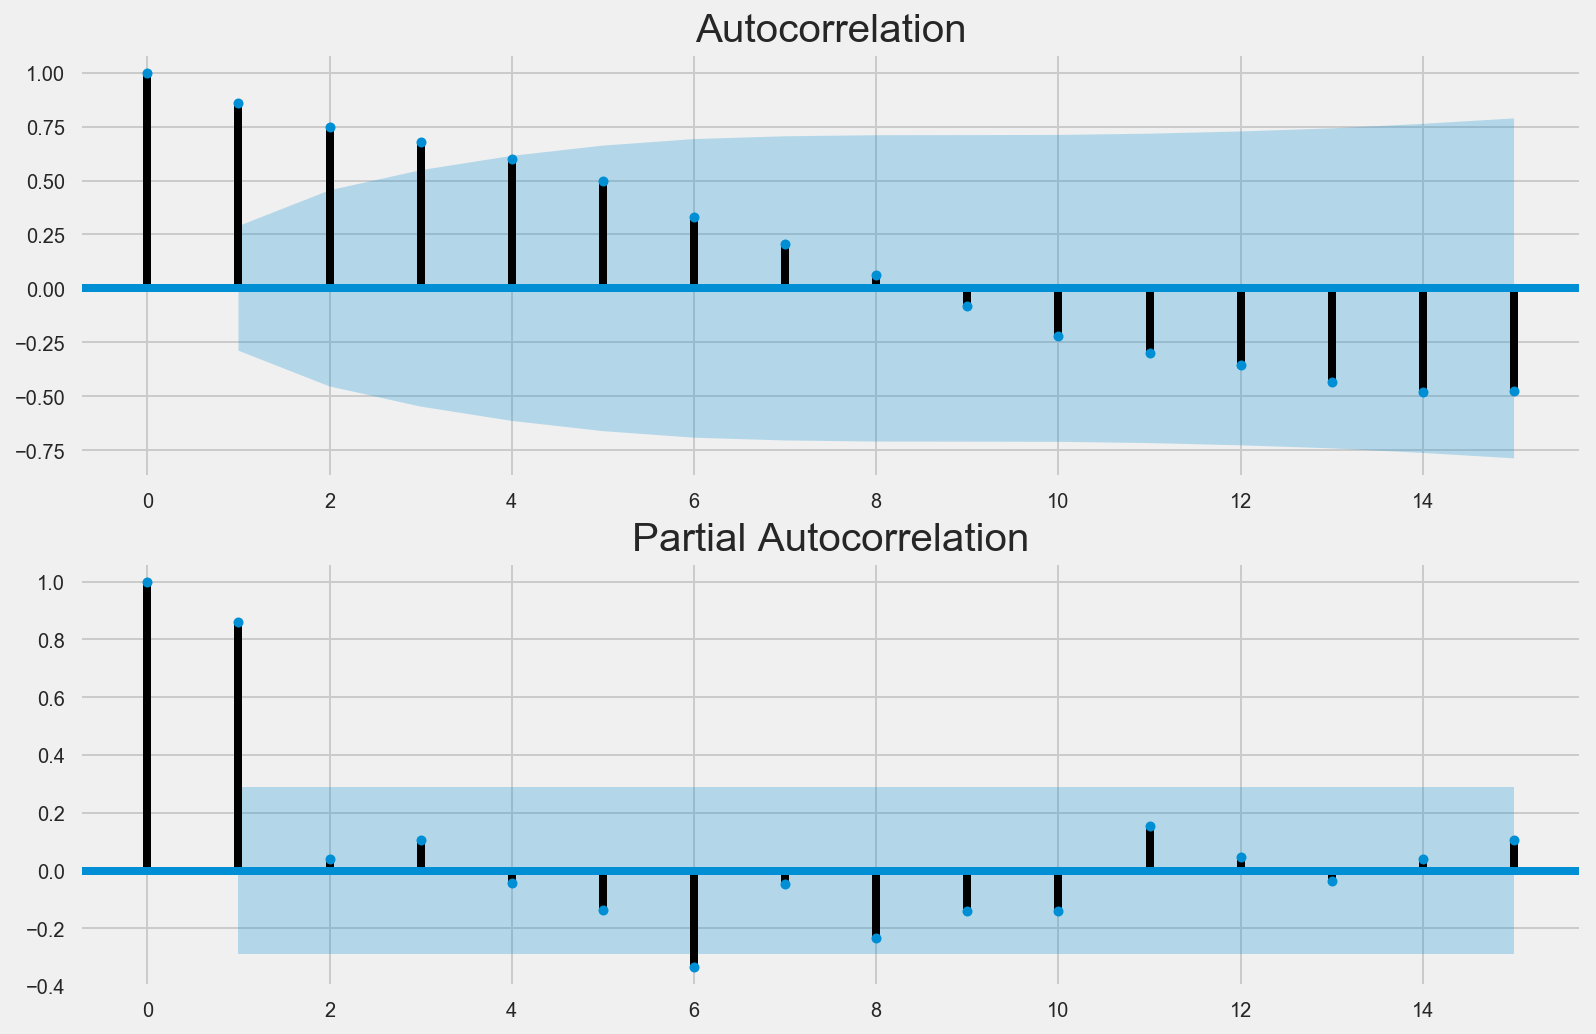

In [23]:
# Check if AR = 1 for a different region 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gty['South_America'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gty['South_America'], lags=15, ax=ax2)

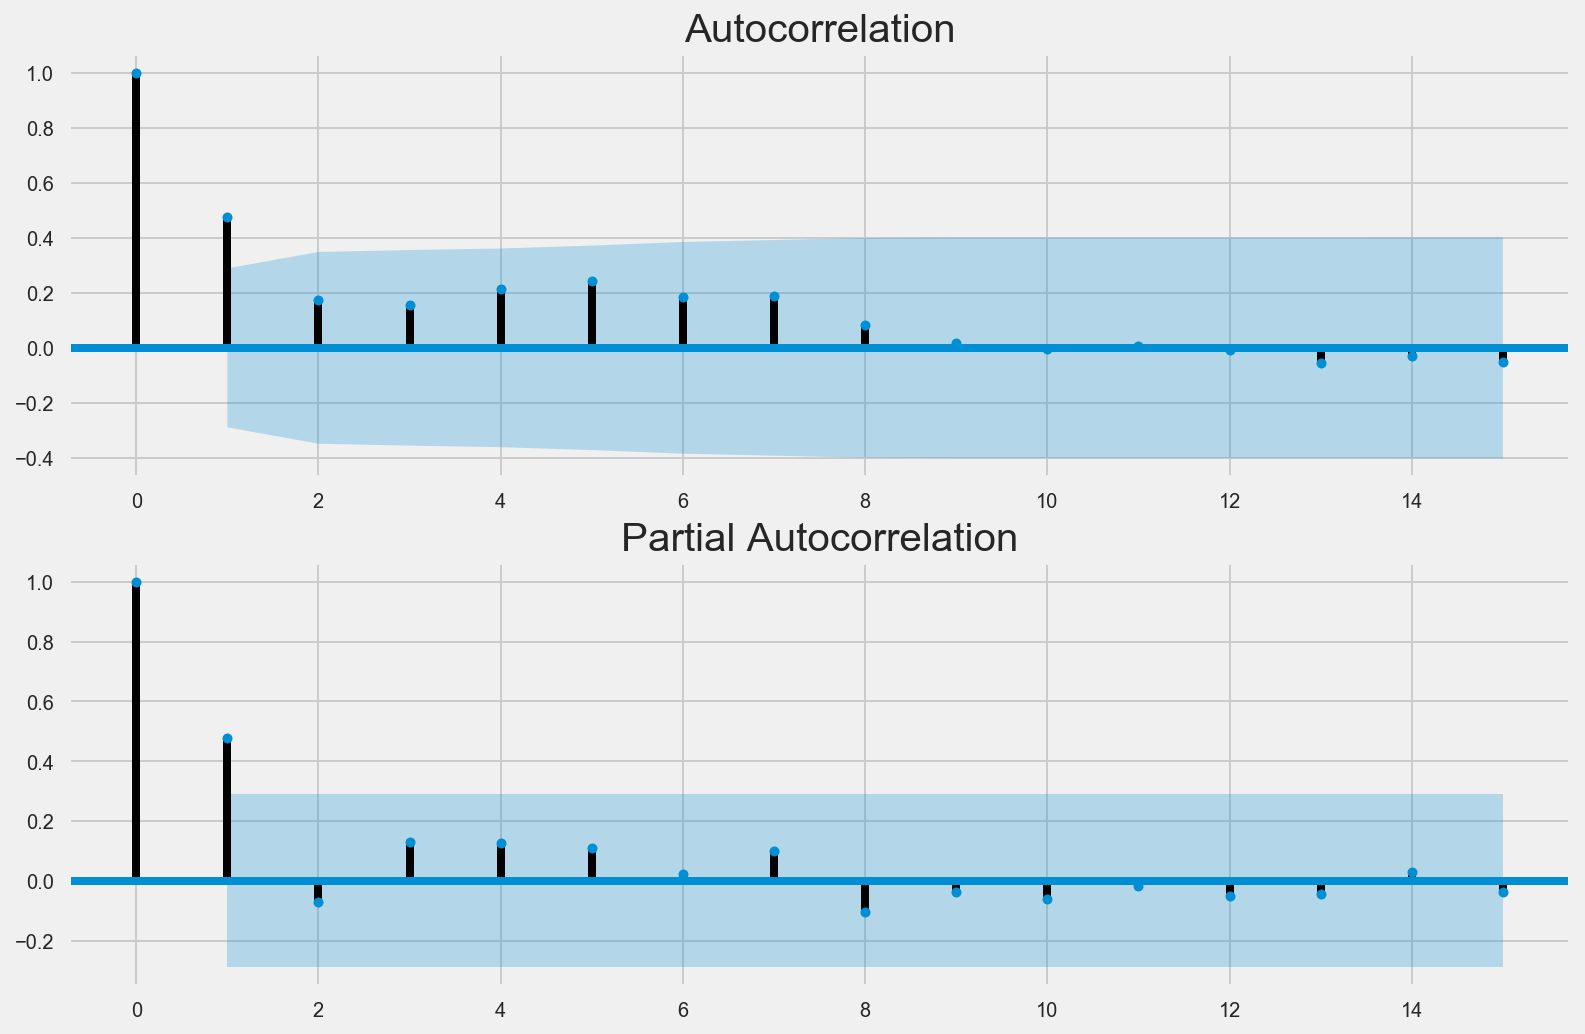

In [24]:
# Check if AR = 1 for a 3rd region
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gty['North_America'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gty['North_America'], lags=15, ax=ax2)

##### Observations on time series autocorrelations
- Data exhibits an AR=1 model.   
- To further confirm, will check AIC of models built with varying AR and MA paramters.  

In [25]:
# ARMA wants date in index
# First create a year column for use later

gty['Year']=gty.index
gty.index= pd.to_datetime(gty.index)      

In [26]:
# Use statsmodel ARMA to see if AR = 1 makes sense - AR 1, MA 0 model
from statsmodels.tsa.arima_model import ARMA
gty['Total_attacks_float']=gty.Total_attacks.astype(float)   # ARMA wants float
model = ARMA(gty.Total_attacks_float,(1,0)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Total_attacks_float   No. Observations:                   46
Model:                      ARMA(1, 0)   Log Likelihood                -394.583
Method:                        css-mle   S.D. of innovations           1245.512
Date:                 Tue, 26 Sep 2017   AIC                            795.165
Time:                         15:50:07   BIC                            800.651
Sample:                     01-01-1970   HQIC                           797.220
                          - 01-01-1970                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5713.6561   4274.743      1.337      0.188   -2664.687    1.41e+04
ar.L1.Total_attacks_float     0.9724      0.031     31.672      0.000       0.912       1.033
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0284           +0.0000j            1.0284            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
# For comparison, try MA = 1 model instead
model = ARMA(gty.Total_attacks_float,(0,1)).fit()
model.summary()
# AIC is higher (worse)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Total_attacks_float   No. Observations:                   46
Model:                      ARMA(0, 1)   Log Likelihood                -420.733
Method:                        css-mle   S.D. of innovations           2176.727
Date:                 Tue, 26 Sep 2017   AIC                            847.466
Time:                         15:50:26   BIC                            852.952
Sample:                     01-01-1970   HQIC                           849.521
                          - 01-01-1970                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      3817.6158    635.160      6.010      0.000    2572.724    5062.507
ma.L1.Total_attacks_float     1.0000      0.094     10.688      0.000       0.817       1.183
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [28]:
# For comparison, try AR 2, MA 0 model
model = ARMA(gty.Total_attacks_float,(2,0)).fit()
model.summary()
# Not much different AIC than AR = 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Total_attacks_float   No. Observations:                   46
Model:                      ARMA(2, 0)   Log Likelihood                -391.032
Method:                        css-mle   S.D. of innovations           1154.908
Date:                 Tue, 26 Sep 2017   AIC                            790.065
Time:                         15:50:39   BIC                            797.379
Sample:                     01-01-1970   HQIC                           792.805
                          - 01-01-1970                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4433.3341   2289.953      1.936      0.059     -54.890    8921.559
ar.L1.Total_attacks_float     1.3469      0.138      9.791      0.000       1.077       1.617
ar.L2.Total_attacks_float    -0.4137      0.153     -2.705      0.010      -0.713      -0.114
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1453           +0.0000j            1.1453            0.0000
AR.2            2.1108           +0.0000j            2.1108            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
# For comparsion, try AR 2, MA 1 model
model = ARMA(gty.Total_attacks_float,(2,1)).fit()
model.summary()
# Not much different AIC than AR = 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Total_attacks_float   No. Observations:                   46
Model:                      ARMA(2, 1)   Log Likelihood                -390.985
Method:                        css-mle   S.D. of innovations           1154.278
Date:                 Tue, 26 Sep 2017   AIC                            791.970
Time:                         15:51:06   BIC                            801.113
Sample:                     01-01-1970   HQIC                           795.395
                          - 01-01-1970                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4243.1732   2108.750      2.012      0.051     110.099    8376.247
ar.L1.Total_attacks_float     1.4442      0.337      4.280      0.000       0.783       2.106
ar.L2.Total_attacks_float    -0.5136      0.351     -1.463      0.151      -1.202       0.174
ma.L1.Total_attacks_float    -0.1073      0.357     -0.301      0.765      -0.807       0.592
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2335           +0.0000j            1.2335            0.0000
AR.2            1.5784           +0.0000j            1.5784            0.0000
MA.1            9.3161           +0.0000j            9.3161            0.0000
-----------------------------------------------------------------------------
"""

##### Conclusion is that AR = 1 model is best fit without overfitting
- Therefore, best guess of 1993 data is based on years immediately surrounding (1992 and 1994)

##### Given no other evidence, I would average 1992 and 1994 values to get 1993 values.
- However in the back of the codebook, it indicates that there were 4954 incidents (I assume attacks) in 1993.   
- This is much closer to the 1992 number (5073) than the 1994 number (3458).    So I will take a scaled average of 
  those two years.

In [30]:
# Compute scaling factor from 1992 to 1993 
attacks_92 = 5073.
attacks_93 = 4954.
attacks_94 = 3458.
scale_factor_92_to_93 = (attacks_93-attacks_94) / (attacks_92-attacks_94)
print scale_factor_92_to_93

0.926315789474


In [113]:
# Estimate the # of bombings in 1993 given the # of bombings in 1992 and the scaling factor. 
bombings_92 = 1738.
bombings_93 = bombings_92*scale_factor_92_to_93
print 'Estimate of 1993 bombings is '+str(int(bombings_93))


Estimate of 1993 bombings is 1609


In [114]:
# Another way to check if this estimate is reasonable is to see if bombings and total attacks declined at about the 
# same rate from 92 to 94
bombings_94 = 1153.
attacks_94_to_92 = attacks_94 / attacks_92
bombings_94_to_92 = bombings_94 / bombings_92
print 'Ratio of attacks in 1994 vs. 1992 was '+str(attacks_94_to_92)
print 'Ratio of bombings in 1994 vs. 1992 was '+str(bombings_94_to_92)

Ratio of attacks in 1994 vs. 1992 was 0.681647940075
Ratio of bombings in 1994 vs. 1992 was 0.663406214039


##### Since attacks and bombings declined at a similar rate, and bombings make up about 1/3 of attacks, I feel that the estimate of 1609 is well justified

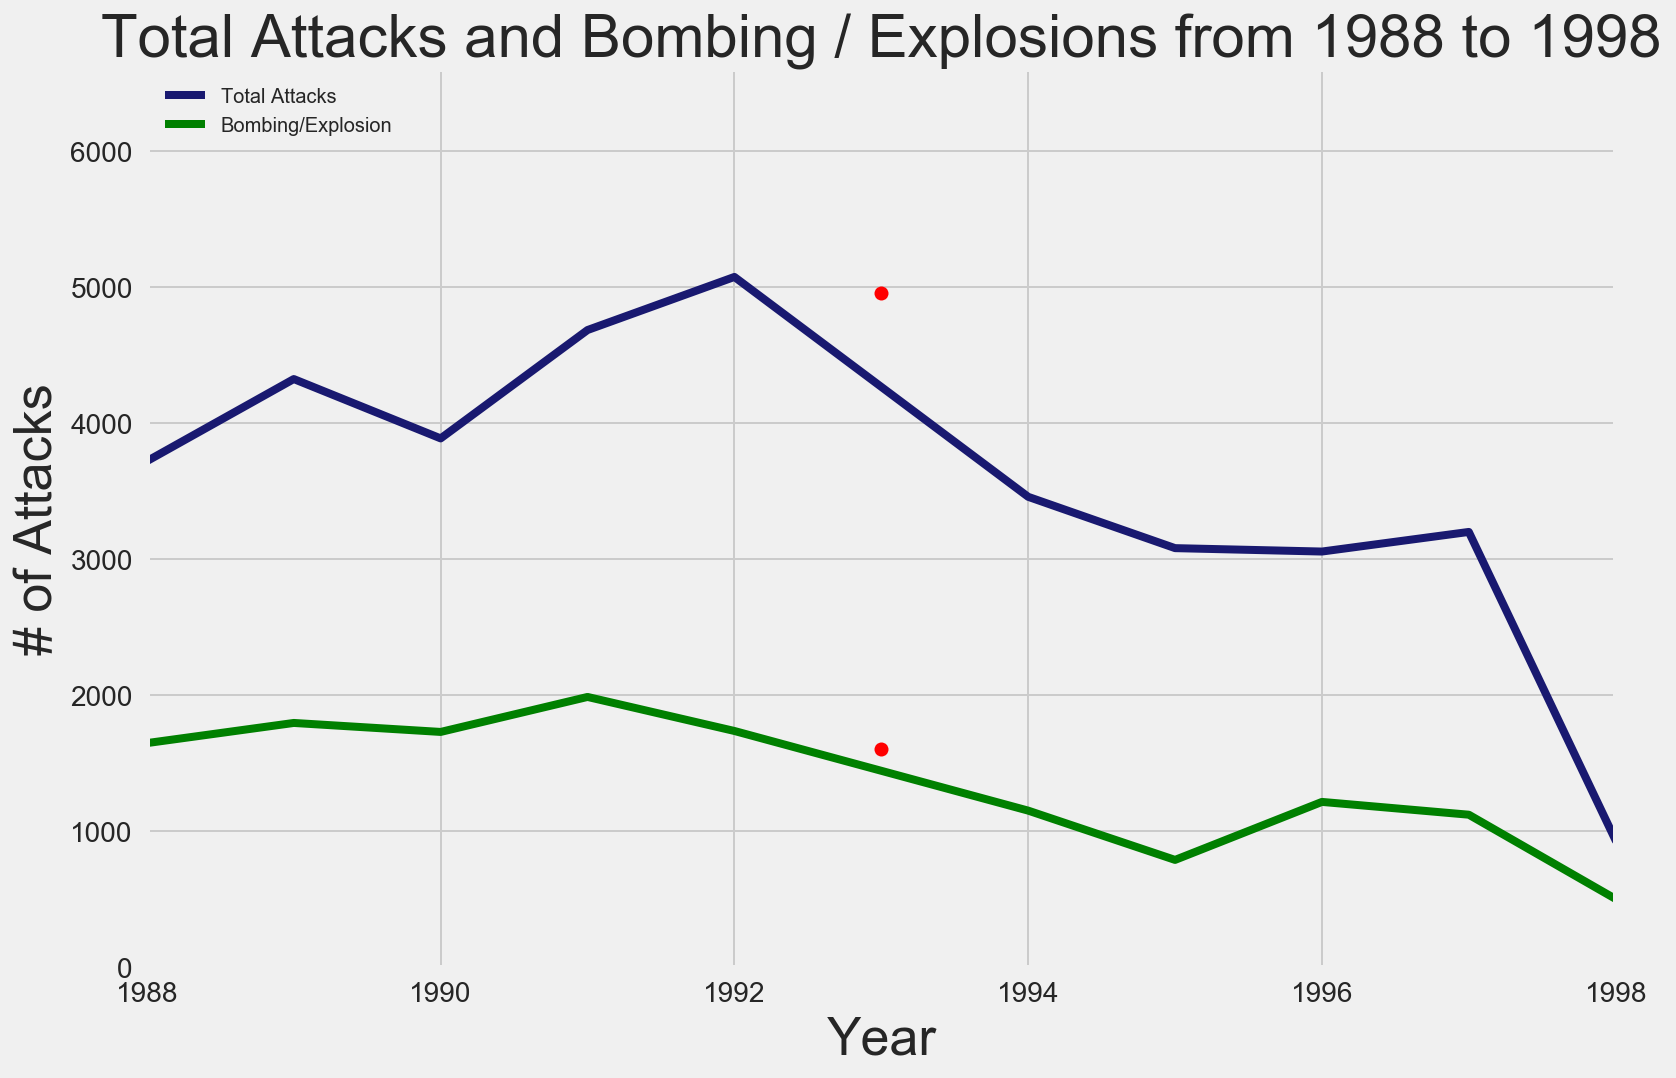

In [31]:
# Create a plot with attacks and bombings with 1993 imputed value

fig=plt.figure(figsize=(12,8))
plt.title('Total Attacks and Bombing / Explosions from 1988 to 1998',fontsize=30)
ax1=sns.tsplot(gty['Total_attacks'],time=gty.index, color='midnightblue',condition='Total Attacks')
ax2=sns.tsplot(gty['Bombing/Explosion'],time=gty.index, color='green',condition= 'Bombing/Explosion')
plt.xlim(1988,1998)
plt.ylim(0,6600)
x_vals = [1988,1990,1992,1994,1996,1998]
plt.xticks(x_vals)
plt.ylabel('# of Attacks',fontsize=26)
plt.xlabel('Year',fontsize=26)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
ax1.plot(1993, 4954,'or')
ax2.plot(1993, 1609,'or')
fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.1)
plt.savefig('1993 imputed values.png')

### Move to Bayesian Analysis

- Going to compare attacks in Central America before and after the Guatemala peace accords that were signed on Dec 28th, 1996.   

In [34]:
# Set up Bayesian model using pymc
import pymc3 as pm

In [35]:
# Want to compare whether the % of worldwide terrorist incidents in Central America has increased or decreased 
# since the Guatemala peace accords at the end of 1996

# As a prior, assume 1/12 of attacks happen by region, normally distributed, with a SD of 1/20
mean_prior_mean = 1/12.
mean_prior_std = 1/20.


In [36]:
# Setup prior means 

with pm.Model() as model:
    before96_mean = pm.Normal('Before96_mean', mean_prior_mean, sd=mean_prior_std)
    after96_mean = pm.Normal('After96_mean', mean_prior_mean, sd=mean_prior_std)

In [37]:
# Set lower and upper bounds for std dev. Use uniform distribution for prior

std_prior_lower = 0.
std_prior_upper = 0.5

with model:
    before96_std = pm.Uniform('Before96_std', lower=std_prior_lower, upper=std_prior_upper)
    after96_std = pm.Uniform('After96_std', lower=std_prior_lower, upper=std_prior_upper)

In [38]:
# Setup the observed values. Using the ratio of Central America vs. total

b96 = (gty[gty.Year<= 1996].Central_America_Caribbean.values)/(gty[gty.Year<= 1996].Total_attacks.values)
a96 = (gty[gty.Year>= 1996].Central_America_Caribbean.values)/(gty[gty.Year>= 1996].Total_attacks.values)
print b96
print a96

[ 0.01075269  0.0106383   0.00604839  0.01268499  0.01896552  0.01216216
  0.04875406  0.0181956   0.13040629  0.22886133  0.40195342  0.44410058
  0.3913556   0.2989547   0.19484979  0.26758148  0.13741259  0.17776382
  0.13306452  0.11635438  0.08129663  0.15566944  0.04178987  0.05205321
  0.05452775  0.03795812]
[  3.79581152e-02   3.65625000e-02   1.07181136e-03   5.73476703e-03
   7.72200772e-03   4.19507079e-03   2.25225225e-03   6.33914422e-03
   4.30292599e-03   1.49328024e-03   1.81884322e-03   1.23418698e-03
   0.00000000e+00   1.90718373e-03   2.07382829e-04   1.97199763e-04
   1.17647059e-04   1.16705569e-03   2.96559905e-04   6.73309992e-05
   2.22419929e-04]


In [39]:
# Setup likelihoods, assuming normal.  This brings in prior distributions and observed data.

with model:
    before96 = pm.Normal('Before96', mu=before96_mean, sd=before96_std, observed=b96)
    after96 = pm.Normal('After96', mu=after96_mean, sd=after96_std, observed=a96)

In [40]:
# Start Markov chain

t0 = time.time()
with model:
    trace = pm.sample(2500, njobs=4)
t1 = time.time()

print t1 - t0

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -68.659:  16%|█▌        | 31317/200000 [00:02<00:14, 11612.16it/s]
Convergence archived at 31600
Interrupted at 31,600 [15%]: Average Loss = -1.2755
100%|██████████| 3000/3000 [00:05<00:00, 592.44it/s]


99.1307239532


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c3cad10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128894810>]], dtype=object)

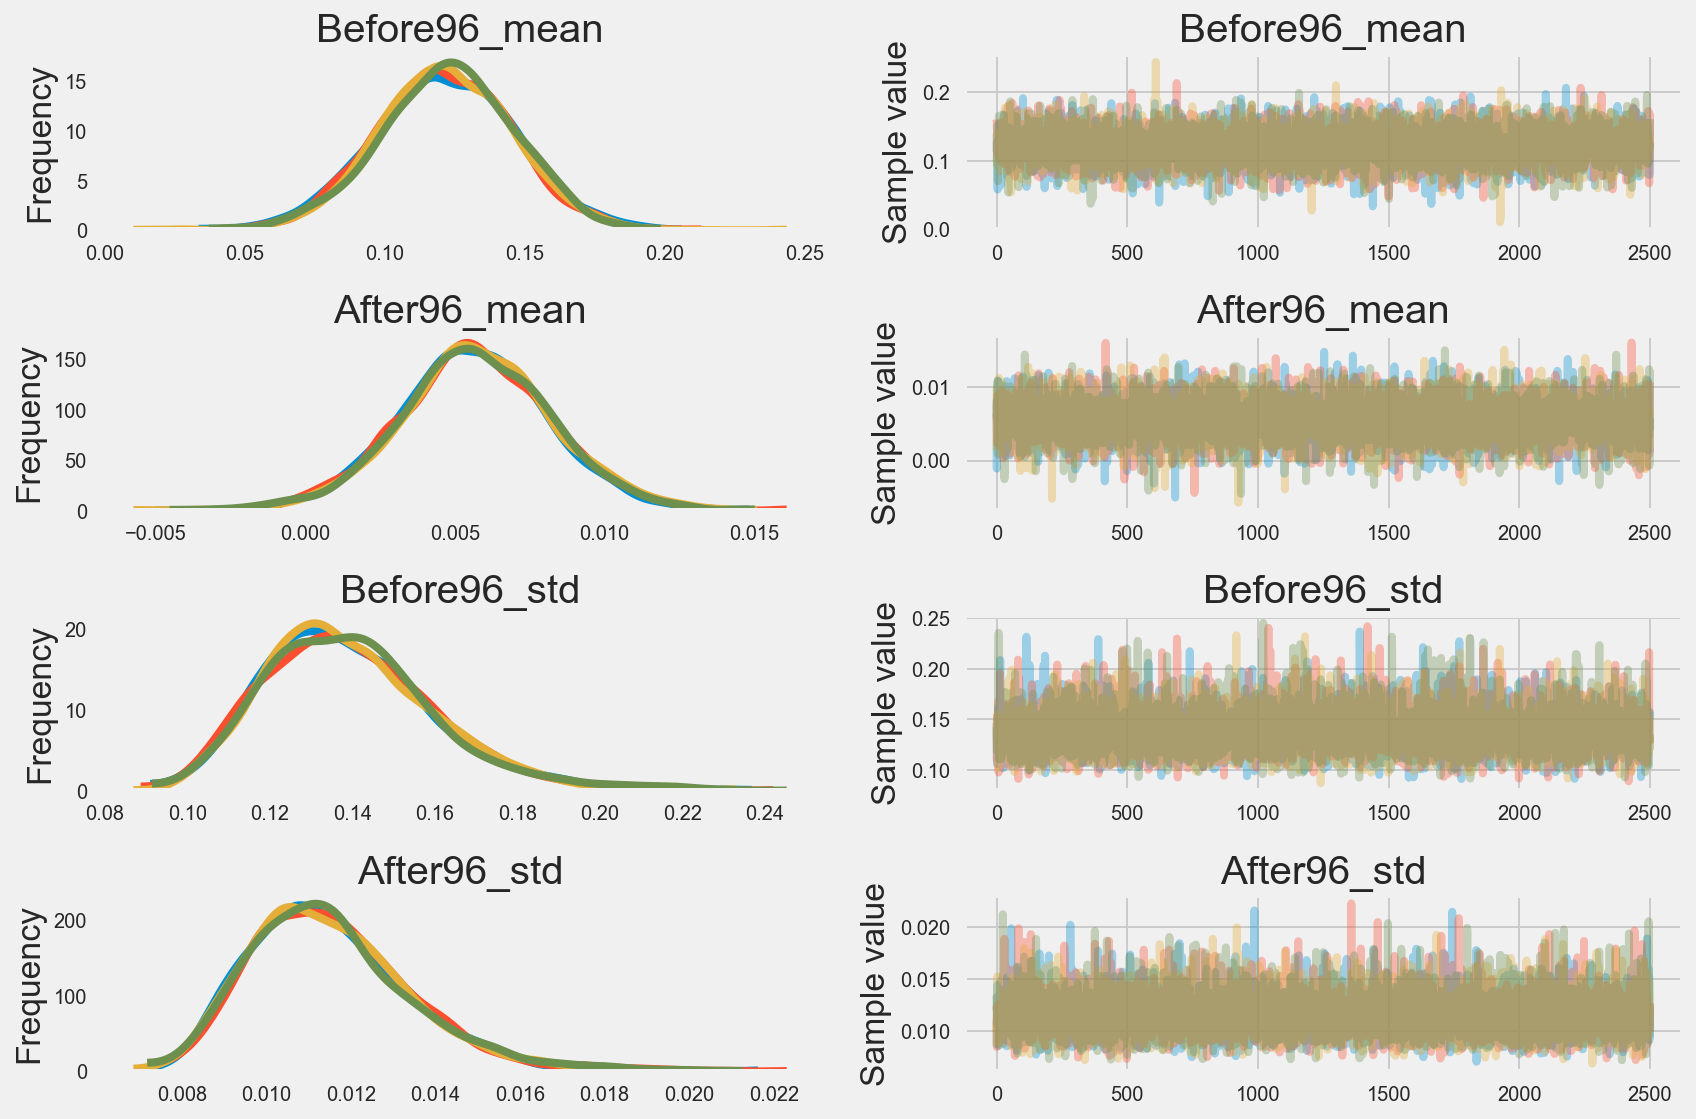

In [41]:
# Plot traceplots, showing the convergence of each component
pm.traceplot(trace)

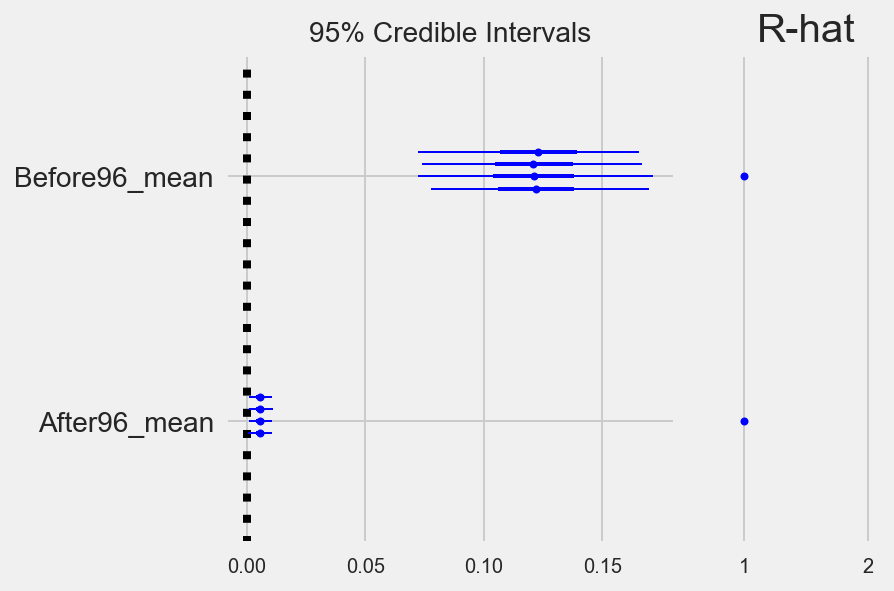

In [42]:
# Compare credible intervals
pm.forestplot(trace[100:], varnames=[v.name for v in model.vars[:2]])
plt.savefig('Central America credible intervals.png')

([<matplotlib.axis.XTick at 0x1289d3c50>,
 <a list of 7 Text xticklabel objects>)

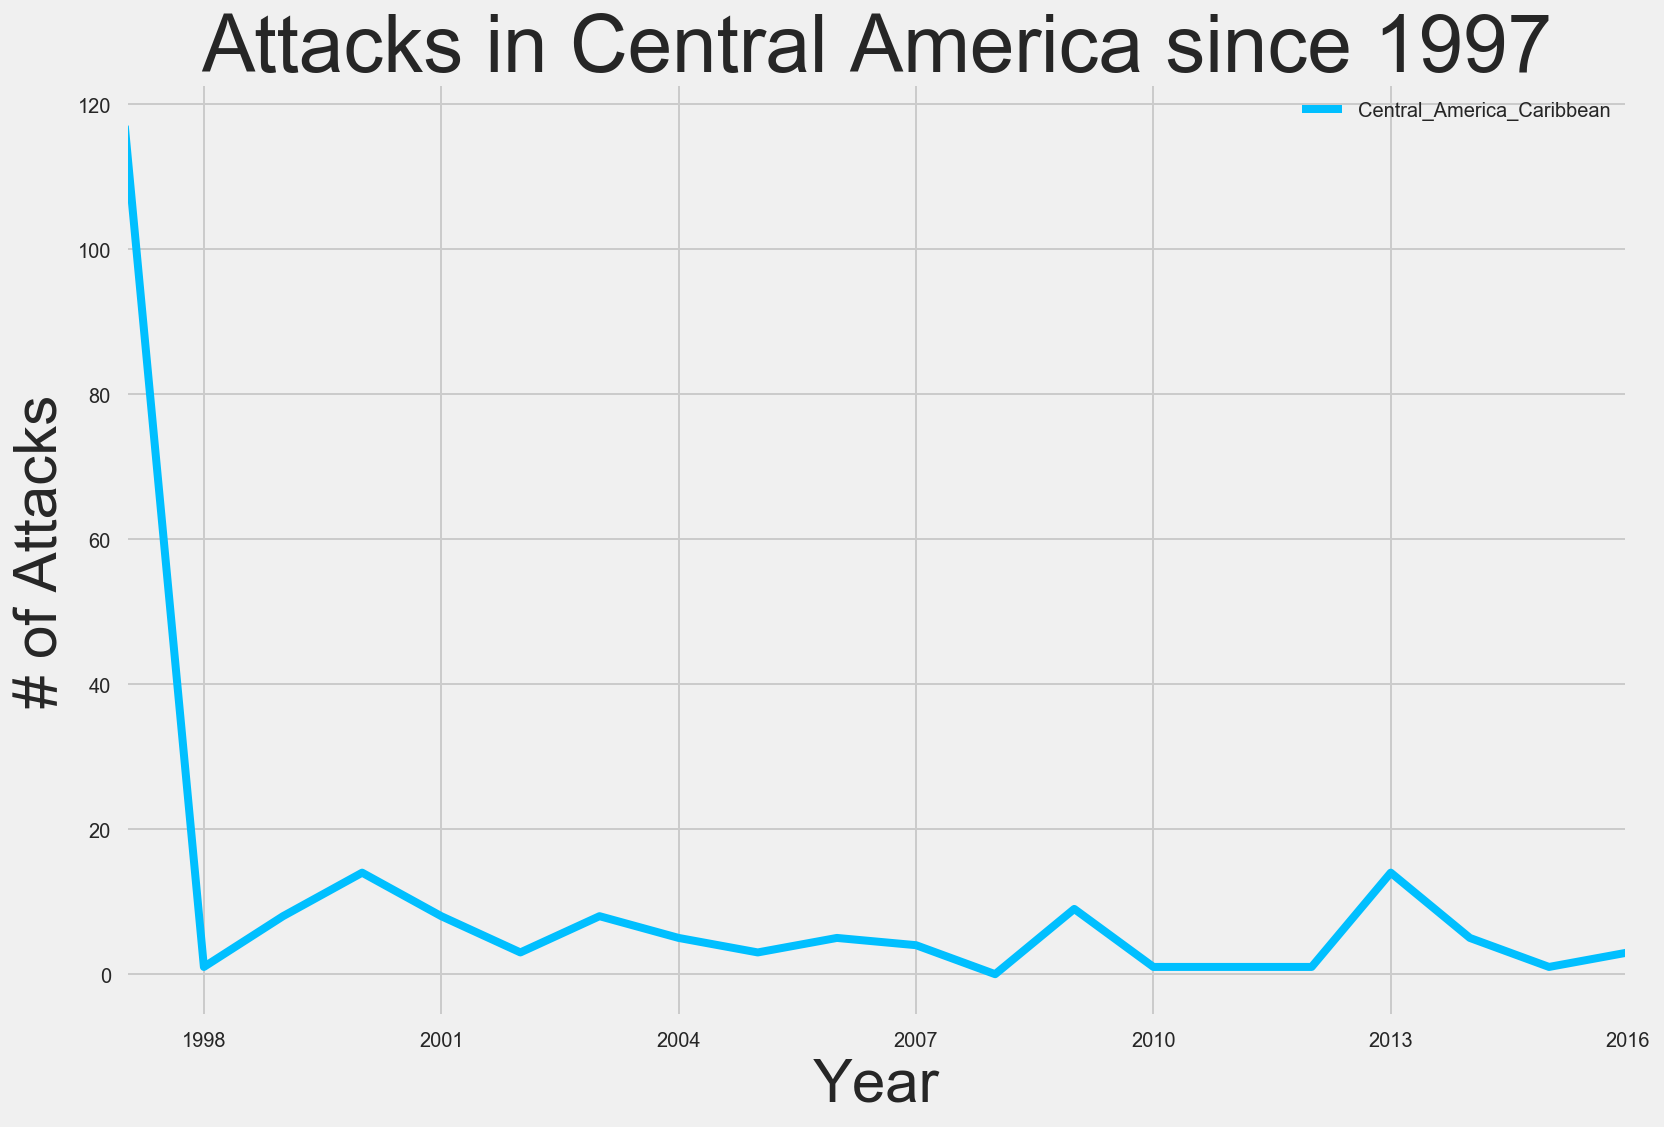

In [43]:
# Do plots of data since and before 1997 to confirm that the difference is as dramatic as appears to be

fig=plt.figure(figsize=(12,8))
plt.title('Attacks in Central America since 1997',fontsize=40)
plt.ylabel('# of Attacks',fontsize=30)
ax1=sns.tsplot(gty[gty.Year>1996].Central_America_Caribbean,time=gty[gty.Year>1996].Year,color='deepskyblue',condition='Central_America_Caribbean')
plt.xlabel('Year',fontsize=30)
plt.xlim(1997,2016)
x_vals = [1998,2001,2004,2007,2010,2013,2016]
plt.xticks(x_vals)

([<matplotlib.axis.XTick at 0x12c4be0d0>,
 <a list of 6 Text xticklabel objects>)

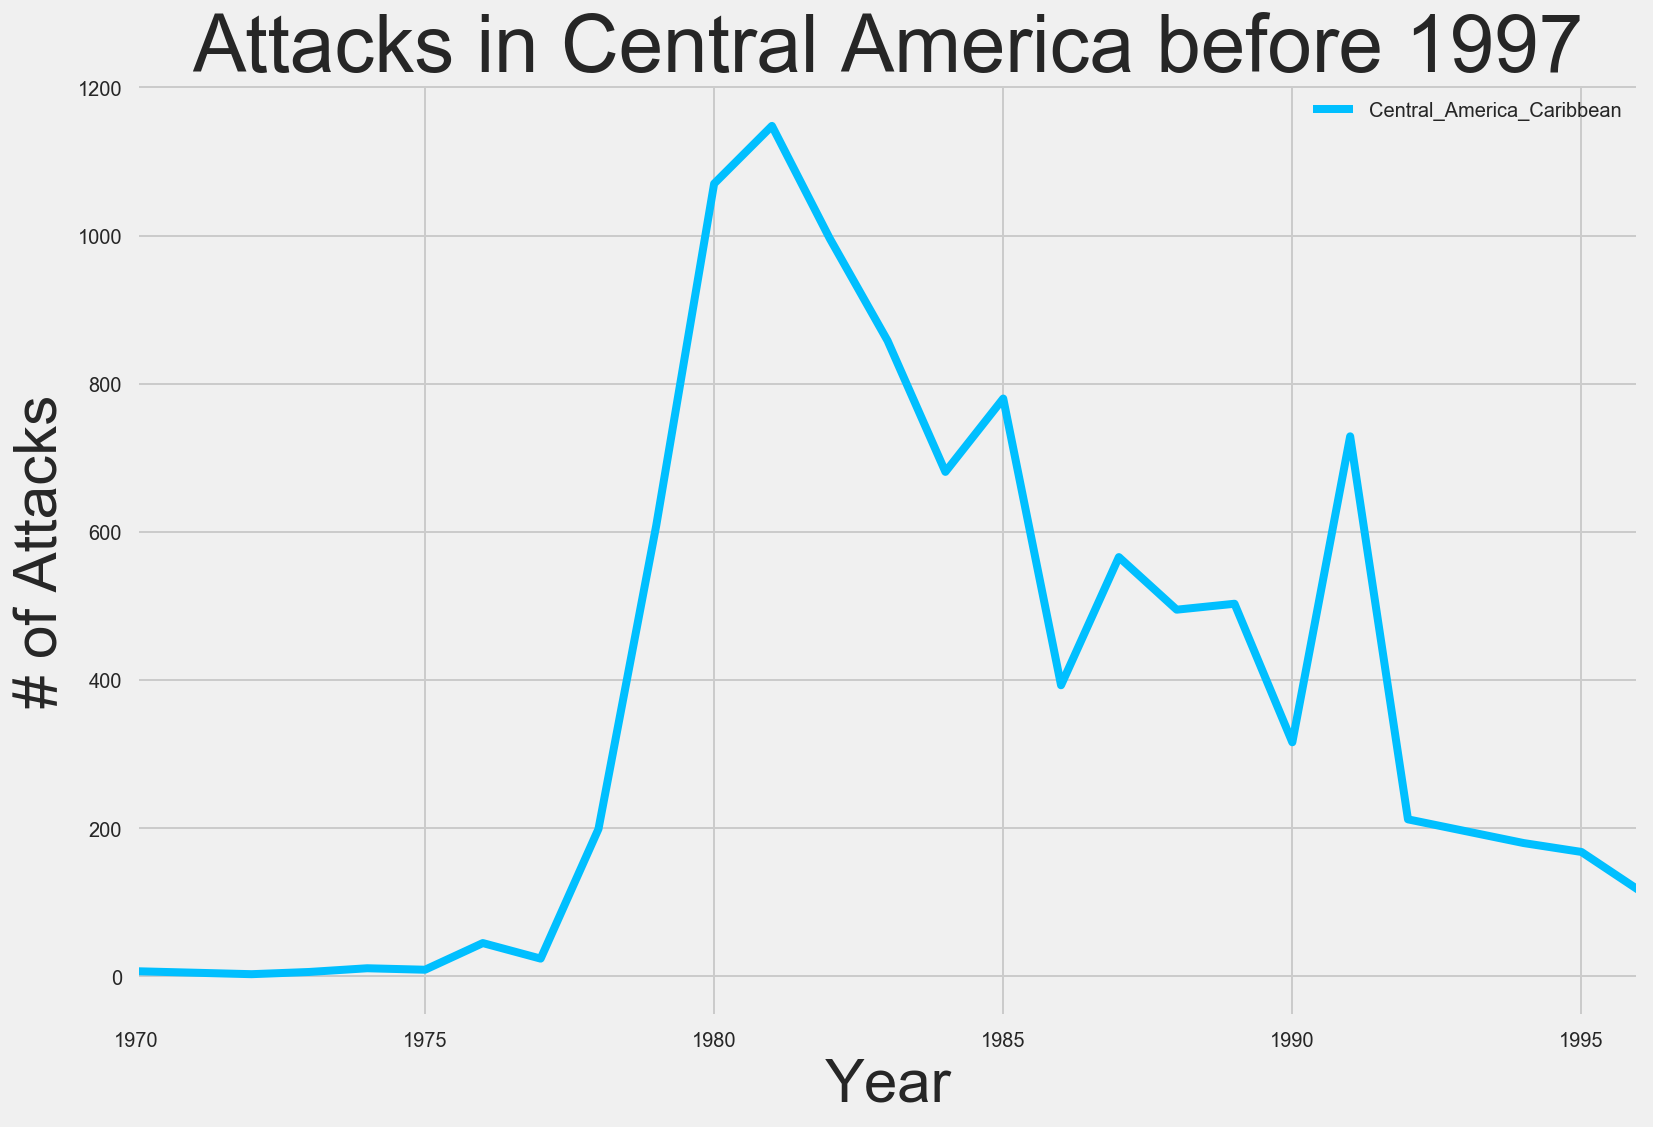

In [44]:
# Plot of data before 1997 

fig=plt.figure(figsize=(12,8))
plt.title('Attacks in Central America before 1997',fontsize=40)
plt.ylabel('# of Attacks',fontsize=30)
ax1=sns.tsplot(gty[gty.Year<=1996].Central_America_Caribbean,time=gty[gty.Year<=1996].Year,color='deepskyblue',condition='Central_America_Caribbean')
plt.xlabel('Year',fontsize=30)
plt.xlim(1970,1996)
x_vals = [1970,1975,1980,1985,1990,1995]
plt.xticks(x_vals)


##### Conclude that the ratio of attacks in Central America to the full world is significantly less after the Guatemalan peace accords than before.

##### However, this may not be due to the Guatemalan peace accords only since I'm looking at many countries over a broad time span
- Look specifically at Guatemala for 10 years before and after the peace accords


In [46]:
# Look at Guatemala specifically

gtd[(gtd.country==83)].groupby('iyear').attacktype1.agg('count')


iyear
1970      4
1971      1
1974      1
1975      5
1976     13
1977      8
1978     29
1979     60
1980    281
1981    399
1982    354
1983    117
1984     74
1985     63
1986     31
1987     56
1988     29
1989     79
1990     83
1991     77
1992     48
1994     84
1995     82
1996     26
1997     26
1999      1
2000      1
2001      2
2003      3
2004      2
2006      4
2012      1
2013      6
Name: attacktype1, dtype: int64

###### Compare number of attacks in Guatemala for 10 years before and after peace accords

In [47]:
# Take average attacks by country as prior (sum of total attacks / 1004 regions)

mean_prior_mean = gty.Total_attacks.mean()/1004
mean_prior_std = gty.Total_attacks.std()/ (1004**0.5)    # think this is correct
print mean_prior_mean
print mean_prior_std

3.6885068422
117.217697651


In [48]:
# Setup prior means with negative binomial distribution
# Two paramaters mu (similar to expected value) and alpha which is r / p.   p is the probability
# Lacking a better theory, I used the standard deviation for this.

with pm.Model() as model:
    before96_mean = pm.NegativeBinomial('Before96_mean', mean_prior_mean, mean_prior_std)
    after96_mean = pm.NegativeBinomial('After96_mean', mean_prior_mean, mean_prior_std)

In [49]:
# Setup lower and upper bounds for std dev.  Use uniform distribution for prior.

std_prior_lower = 1.0
std_prior_upper = 50.0

with model:
    before96_std = pm.Uniform('Before96_std', lower=std_prior_lower, upper=std_prior_upper)
    after96_std = pm.Uniform('After96_std', lower=std_prior_lower, upper=std_prior_upper)

In [50]:
# Setup the observed values

b96 = gty[(gty.Year<= 1996)&(gty.Year>= 1987)].Central_America_Caribbean.values
a96 = gty[(gty.Year>= 1997)&(gty.Year<= 2005)].Central_America_Caribbean.values
print b96
print a96

[ 566.  495.  503.  316.  729.  212.  180.  168.  116.]
[ 117.    1.    8.   14.    8.    3.    8.    5.    3.]


In [51]:
# Setup likelihoods, assuming normal. They bring in prior distributions and observed data

with model:
    before96 = pm.Normal('Before96', mu=before96_mean, sd=before96_std, observed=b96)
    after96 = pm.Normal('After96', mu=after96_mean, sd=after96_std, observed=a96)

In [52]:
# Start Markov chain

t0 = time.time()
with model:
    trace = pm.sample(2500, njobs=-1)
t1 = time.time()

print t1 - t0

Assigned Metropolis to Before96_mean
Assigned Metropolis to After96_mean
Assigned NUTS to Before96_std_interval__
Assigned NUTS to After96_std_interval__
 98%|█████████▊| 2938/3000 [00:04<00:00, 709.51it/s]/Users/matthewterribile/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3000/3000 [00:05<00:00, 591.52it/s]


20.8707201481


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128628c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c2cf050>]], dtype=object)

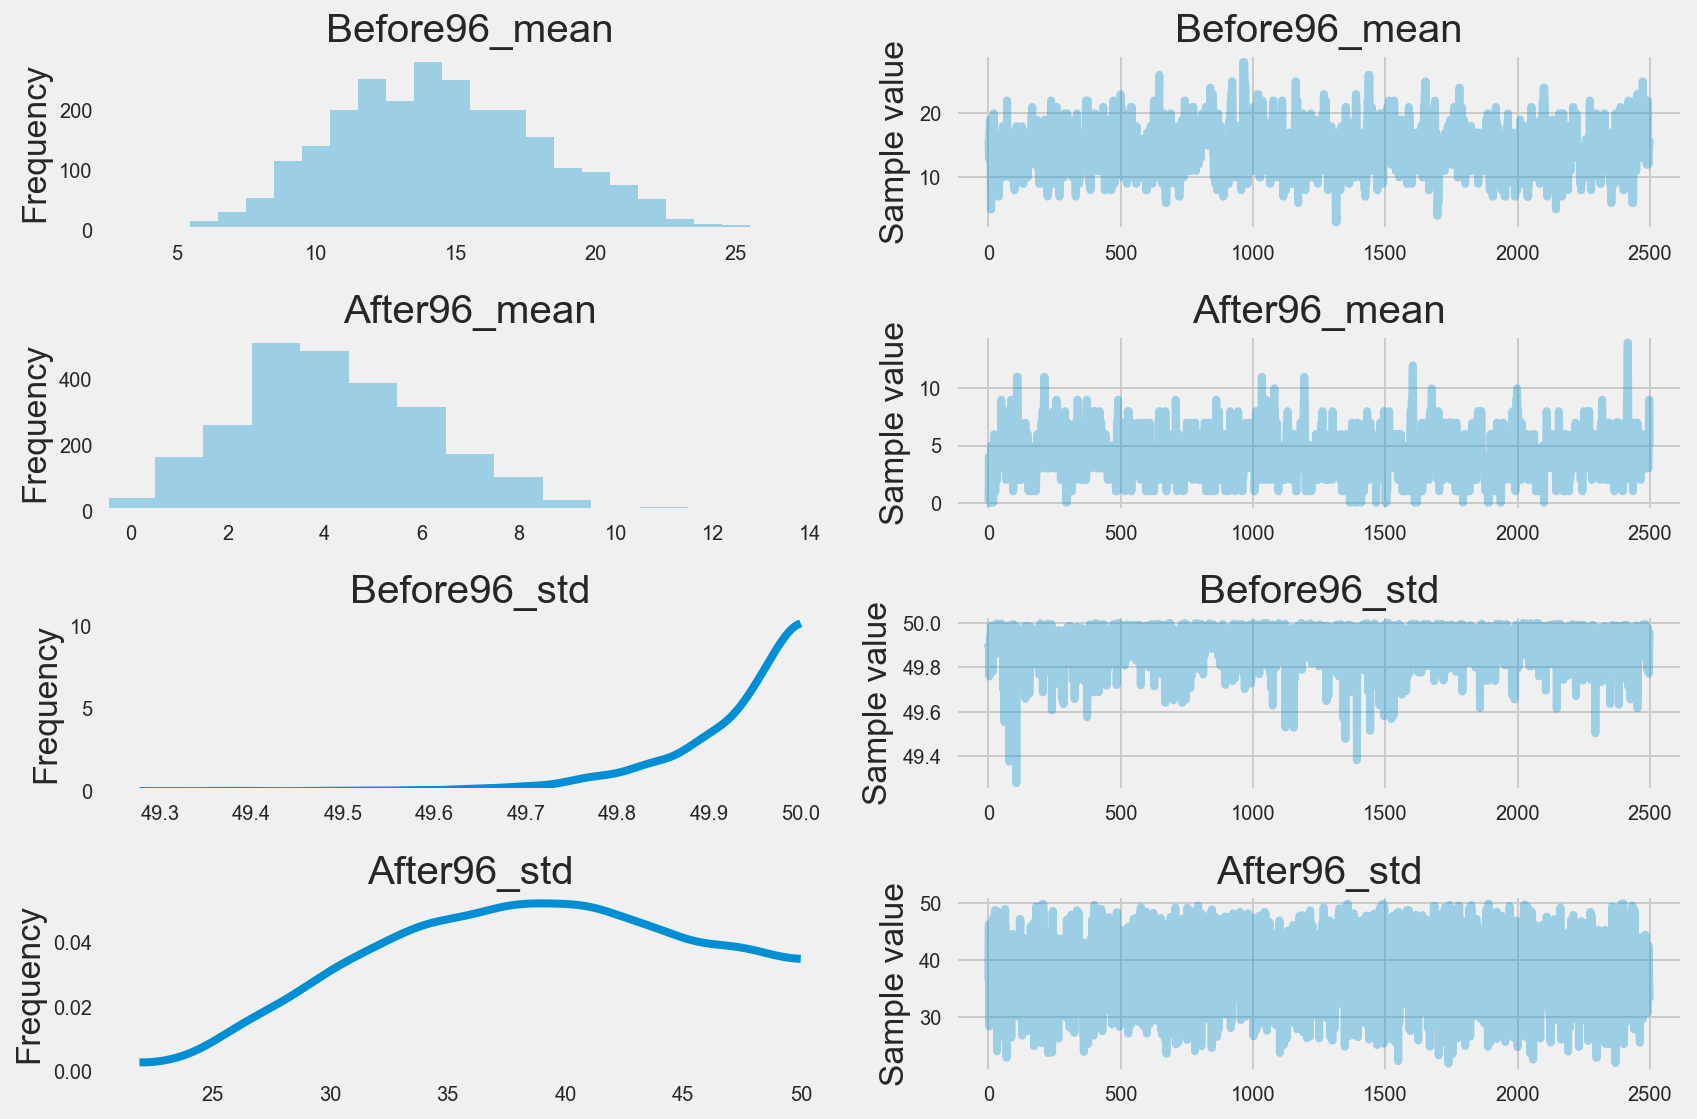

In [53]:
# Plot traceplots, showing the convergence of each component
pm.traceplot(trace)

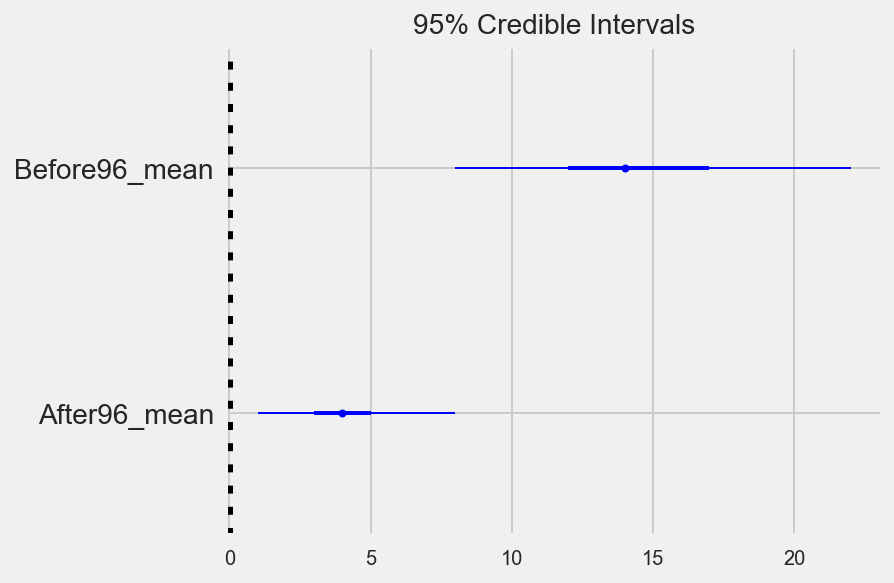

In [54]:
# Compare credible intervals - Guatemala only, 10 years before and after

pm.forestplot(trace[500:], varnames=[v.name for v in model.vars[:2]])
plt.savefig('Guatemala credible intervals.png')

##### There is a difference in the # of attacks per year in Guatemala before and after 1996, although there is slight overlap in the 95% credible interval